# Task 1: provide one implementation of each model, the one that gave you the best results after tuning.

In [16]:
# Dependencies
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.text import Tokenizer
from keras.layers import TextVectorization
from keras.models import Sequential
from keras.layers import Dense
from keras import optimizers
import scipy
import re
import matplotlib.pyplot as plt
from keras.layers import Flatten
from keras.layers import Embedding
from keras import initializers
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Conv1D, GlobalMaxPooling1D
import numpy as np
from keras.layers import LSTM, Dropout
from transformers import BertTokenizer, BertModel
import torch
from tensorflow.keras.regularizers import l1, l2
import keras_tuner as kt
from sklearn.model_selection import KFold, StratifiedKFold
import statistics
from tensorflow.keras.callbacks import EarlyStopping
import seaborn as sns
from scipy import stats
from sklearn.metrics import confusion_matrix

In [2]:
# Loading in the data from csv file
train = pd.read_csv('train.csv')
test = pd.read_csv('test-1.csv')

X = train['text']
y_train = train['label']

print(y_train.shape)

X_test = test['text']
y_test = test['label']

(2003,)


In [127]:
# Function to pre-process data to remove (stop words)
import string
import re
import gensim
from gensim.parsing.preprocessing import remove_stopwords

def simple_preprocess(text):

    text = remove_stopwords(text)
    
    return text

# Apply the simplified preprocessing
train_processed= train['text'].apply(simple_preprocess)
test_processed= test['text'].apply(simple_preprocess)

print(train_processed.shape)

(2003,)


# Helper Functions for (plots, tables, Crossvalidation)

In [51]:
# Cross validation Function
def cross_validate_model(X_train, y_train, model_fn, n_splits, epochs, batch_size, save_path, random_state=1):
    """Perform cross-validation and return results and training history."""
    # Set random seed for reproducibility
    tf.keras.utils.set_random_seed(random_state)
    
    # Initialize cross-validation
    skf = StratifiedKFold(n_splits=n_splits, shuffle=True)
    val_acc = []
    val_loss = []
    all_histories = []

    # For ROC curve
    all_val_labels = []
    all_val_preds = []

    # Track best model
    best_val_metric = float('inf')
    
    for fold, (train_idx, val_idx) in enumerate(skf.split(X_train, y_train)):
        # Get data for this fold
        X_train_fold, X_val_fold = X_train[train_idx], X_train[val_idx]
        y_train_fold, y_val_fold = y_train[train_idx], y_train[val_idx]
        
        # Create model for this fold
        fold_model = model_fn()
        
        # Set up early stopping
        early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
        
        # Train model
        history = fold_model.fit(X_train_fold, y_train_fold, epochs=epochs, batch_size=batch_size, validation_data=(X_val_fold, y_val_fold), callbacks=[early_stopping], verbose=1)
        
        # Save training history
        all_histories.append(history.history)

        # Get predictions for ROC curve
        y_val_pred = fold_model.predict(X_val_fold, verbose=0)

        # Store validation labels and predictions
        all_val_labels.extend(y_val_fold)
        all_val_preds.extend(y_val_pred)

        # storing metrics from this fold
        best_epoch_idx = np.argmin(history.history['val_loss'])
        fold_val_loss = history.history['val_loss'][best_epoch_idx]
        val_loss.append(history.history['val_loss'][best_epoch_idx])
        val_acc_key = 'val_accuracy' if 'val_accuracy' in history.history else 'val_acc'
        val_acc.append(history.history[val_acc_key][best_epoch_idx])

        # Check if this is the best model so far
        if fold_val_loss < best_val_metric:  # Using val_loss as metric
            best_val_metric = fold_val_loss
            best_model = fold_model
            print(f"New best model found in fold {fold+1}")

        print("Cross Validation Results - Final metrics of fold")
        print(f" 'val_acc: ' {(history.history[val_acc_key][best_epoch_idx])}")
        print(f" 'val_loss: ' {(history.history['val_loss'][best_epoch_idx])}")
        print(f" 'Best epoch for this fold: ' {best_epoch_idx}")
    
    # Calculate mean values
    mean_val_acc = sum(val_acc) / len(val_acc)
    mean_val_loss = sum(val_loss) / len(val_loss)

    print("Average Cross Validation Results")
    print(f" 'mean_val_acc: ' {mean_val_acc}")
    print(f" 'mean_val_loss: ' {mean_val_loss}")

    # Save the best model weights
    if best_model is not None:
        best_model.save_weights(save_path)
        print(f"Best model weights saved to {save_path}")

    # Convert lists to arrays for ROC curve calculation
    all_val_labels = np.array(all_val_labels)
    all_val_preds = np.array(all_val_preds)

    return {
        'val_acc': val_acc,
        'val_loss': val_loss,
        'mean_val_acc': mean_val_acc,
        'mean_val_loss': mean_val_loss,
        'histories': all_histories,
        'val_labels': all_val_labels,
        'val_preds': all_val_preds,
        'best_model': best_model
    }

In [5]:
# Function for plotting cross validation results

# Function for plotting cross validation results with loss, accuracy & ROC curves
def plot_cross_validation_results(cv_results):
    """
    Visualize cross-validation results with three plots: loss curves, accuracy curves, and ROC curve
    
    Parameters:
    -----------
    cv_results : dict
        Dictionary containing cross-validation results from cross_validate_model function
    epochs : int
        Number of epochs used for training
    y_test : array-like
        True labels for test data
    y_pred_prob : array-like
        Prediction probabilities for test data
    """
    # Extract data from cv_results
    histories = cv_results['histories']
    val_labels = cv_results['val_labels']
    val_preds = cv_results['val_preds']
    
    # Prepare data for plotting
    max_epochs = max([len(history.get('loss', [])) for history in histories])
    z = np.arange(max_epochs)
    
    # Calculate average training and validation curves
    train_E_avg = np.zeros(max_epochs)
    test_E_avg = np.zeros(max_epochs)
    train_Acc_avg = np.zeros(max_epochs)
    test_Acc_avg = np.zeros(max_epochs)
    
    # Count for averaging
    counts = np.zeros(max_epochs)
    
    # Compute average curves
    for history in histories:
        hist_epochs = len(history['loss'])
        train_E_avg[:hist_epochs] += np.array(history['loss'])
        test_E_avg[:hist_epochs] += np.array(history['val_loss'])
        
        acc_key = 'accuracy' if 'accuracy' in history else 'acc'
        val_acc_key = 'val_accuracy' if 'val_accuracy' in history else 'val_acc'
        
        train_Acc_avg[:hist_epochs] += np.array(history[acc_key])
        test_Acc_avg[:hist_epochs] += np.array(history[val_acc_key])
        counts[:hist_epochs] += 1
    
    # Avoid division by zero
    counts = np.maximum(counts, 1)
    train_E_avg /= counts
    test_E_avg /= counts
    train_Acc_avg /= counts
    test_Acc_avg /= counts
    
    # Create figure with subplots
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20, 5))
    # fig.suptitle('Model Curves', fontsize=16)
    
    # 1. Binary Cross-Entropy Loss
    ax1.plot(z, train_E_avg, label="Train", color='red')
    ax1.plot(z, test_E_avg, label="Validation", color='blue')
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('Binary Cross-Entropy Loss')
    ax1.set_title('Average Cross Validation Training and Validation Loss')
    ax1.legend(loc='upper right')
    ax1.grid(True, linestyle='--', alpha=0.7)
    
    # 2. Training Accuracy
    ax2.plot(z, train_Acc_avg, label="Train", color='red')
    ax2.plot(z, test_Acc_avg, label="Validation", color='blue')
    ax2.set_xlabel('Epochs')
    ax2.set_ylabel('Accuracy')
    ax2.set_title('Average Cross Validation Training and Validation Accuracy')
    ax2.legend(loc='lower right')
    ax2.grid(True, linestyle='--', alpha=0.7)
    
    # 3. ROC Curve
    from sklearn.metrics import roc_curve, auc
    fpr, tpr, _ = roc_curve(val_labels, val_preds)
    roc_auc = auc(fpr, tpr)
    ax3.plot(fpr, tpr, color='red', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
    ax3.set_xlim([0.0, 1.0])
    ax3.set_ylim([0.0, 1.02])
    ax3.set_xlabel('False Positive Rate')
    ax3.set_ylabel('True Positive Rate')
    ax3.set_title('Average Cross Validation ROC Curve')
    ax3.legend(loc="lower right")
    ax3.grid(True, linestyle='--', alpha=0.7)
    
    plt.tight_layout()
    # plt.show()
    
    return fig

In [118]:
# Function for plotting confusion matrix and metrics
def plot_final_results(model, x_test, y_test):
    
    # Get predictions
    y_pred_prob = model.predict(x_test)
    y_pred = np.round(y_pred_prob)  # For binary classification
    
    # Calculate confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    tn, fp, fn, tp = cm.ravel()
    
    # Calculate metrics
    accuracy = (tp + tn) / (tp + tn + fp + fn)
    precision = tp / (tp + fp) if (tp + fp) > 0 else 0
    recall = tp / (tp + fn) if (tp + fn) > 0 else 0
    f1_score = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
    specificity = tn / (tn + fp) if (tn + fp) > 0 else 0
    fpr = fp / (fp + tn) if (fp + tn) > 0 else 0
    fnr = fn / (fn + tp) if (fn + tp) > 0 else 0
    
    # Create metrics data
    metrics = {
        'Metric': ['Accuracy', 'Precision', 'Recall', 'F1 Score', 'Specificity', 'FPR', 'FNR'],
        'Value': [accuracy, precision, recall, f1_score, specificity, fpr, fnr]
    }
    metrics_df = pd.DataFrame(metrics)
    metrics_df['Value'] = metrics_df['Value'].round(2)
    
    # Create figure with two subplots side by side
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
    
    # Plot confusion matrix on the left
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax1)
    ax1.set_title('Confusion Matrix', pad=20)
    ax1.set_ylabel('True Label')
    ax1.set_xlabel('Predicted Label')
    ax1.set_xticklabels(['Negative', 'Positive'])
    ax1.set_yticklabels(['Negative', 'Positive'])
    
    # Create a table on the right subplot
    ax2.axis('off')
    table = ax2.table(
        cellText=metrics_df.values,
        colLabels=metrics_df.columns,
        cellLoc='center',
        loc='center',
        colWidths=[0.3, 0.3]
    )
    table.auto_set_font_size(False)
    table.set_fontsize(12)
    table.scale(1.2, 1.5)
    ax2.set_title('Performance Metrics', pad=20)
    
    plt.tight_layout()
    plt.show()
    
    # Print metrics for reference
    print(f"Accuracy: {accuracy:.2f}")
    print(f"Precision: {precision:.2f}")
    print(f"Recall: {recall:.2f}")
    print(f"F1 Score: {f1_score:.2f}")
    print(f"Specificity: {specificity:.2f}")
    print(f"False Positive Rate: {fpr:.2f}")
    print(f"False Negative Rate: {fnr:.2f}")
    
    return metrics_df

# Loading Word2Vec, Glove & BERT

In [6]:
# Load word2vec & glove models
import kagglehub
from gensim.models import KeyedVectors
from gensim.scripts.glove2word2vec import glove2word2vec

# path_word2vec = kagglehub.dataset_download("leadbest/googlenewsvectorsnegative300")
# path_glove = kagglehub.dataset_download("thanakomsn/glove6b300dtxt")

word2vec_file = '/Users/matthew/.cache/kagglehub/datasets/leadbest/googlenewsvectorsnegative300/versions/2/GoogleNews-vectors-negative300.bin'
word2vec_model = KeyedVectors.load_word2vec_format(word2vec_file, binary=True, limit=50000)

glove_file = '/Users/matthew/.cache/kagglehub/datasets/thanakomsn/glove6b300dtxt/versions/1/glove.6B.300d.txt'
word2vec_output_file = 'glove.6B.300d.txt.word2vec'
glove2word2vec(glove_file, word2vec_output_file)

filename = 'glove.6B.300d.txt.word2vec'
glove = KeyedVectors.load_word2vec_format(filename, binary=False, limit=50000)

/var/folders/2l/g38nhbtn4sj3wlkfc_25hzy00000gn/T/ipykernel_1357/3868437446.py:14: DeprecationWarning: Call to deprecated `glove2word2vec` (KeyedVectors.load_word2vec_format(.., binary=False, no_header=True) loads GLoVE text vectors.).
  glove2word2vec(glove_file, word2vec_output_file)


In [7]:
# Load pre-trained model and tokenizer
from transformers import TFBertModel, BertTokenizer

bert_tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
bert_model = TFBertModel.from_pretrained('bert-base-uncased')

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions w

# Converting reviews into embeddings using Word2Vec, Glove & BERT

In [128]:
# Word2Vec sequences & single vector

#Converting text2Vec 
def text2Vec(list):
    vectors = []
    for row in list:
        tokens = [w.lower() for w in re.sub(r'[^\w\s]','',row).split(' ')]
        temp = []
        for token in tokens:
            if token in word2vec_model:
                temp.append(word2vec_model[token])
        vectors.append(np.mean(temp, axis=0))
    return np.asarray(vectors)

data_train = text2Vec(train_processed)
data_test = text2Vec(test_processed)

print(data_train.shape)

def create_word2vec_sequences(X_train, X_test, word2vec_model, max_words=50000, buffer=10):
    """
    Convert text data to sequences using pre-trained word2vec embeddings.
    """
    # Initialize and fit the tokenizer on training data
    tokenizer = Tokenizer(num_words=max_words)
    tokenizer.fit_on_texts(X_train)
    
    # Convert texts to sequences
    train_sequences = tokenizer.texts_to_sequences(X_train)
    num_words = len(tokenizer.word_index) + 1
    
    # Create embedding matrix from pre-trained word vectors
    embedding_matrix = np.zeros((num_words, 300))
    for word, i in tokenizer.word_index.items():
        if word in word2vec_model:
            embedding_matrix[i] = word2vec_model[word]
    
    # Calculate maximum sequence length
    sequence_lengths = [len(seq) for seq in train_sequences]
    max_length = max(sequence_lengths) + buffer
    
    # Pad sequences to same length
    x_train_seq = pad_sequences(train_sequences, maxlen=max_length)
    
    # Process test data
    test_sequences = tokenizer.texts_to_sequences(X_test)
    x_test_seq = pad_sequences(test_sequences, maxlen=max_length)
    
    print(f"Training data shape: {x_train_seq.shape}")
    print(f"Test data shape: {x_test_seq.shape}")
    print(f"Vocabulary size: {num_words}")
    print(f"Embedding matrix shape: {embedding_matrix.shape}")
    print(f"Maximum sequence length: {max_length}")
    print(f"num words : {num_words}")
    
    return x_train_seq, x_test_seq, embedding_matrix, tokenizer, max_length, num_words

x_train_seq, x_test_seq, embedding_matrix, tokenizer, max_length, num_words = create_word2vec_sequences(
    X_train=train_processed, 
    X_test=test_processed, 
    word2vec_model=word2vec_model
)

(2003, 300)
Training data shape: (2003, 87)
Test data shape: (502, 87)
Vocabulary size: 4892
Embedding matrix shape: (4892, 300)
Maximum sequence length: 87
num words : 4892


In [79]:
# Glove sequences & single vector

#Converting text 2 vec using Glove
def text2Vec_glove(list):
    vectors = []
    for row in list:
        tokens = [w.lower() for w in re.sub(r'[^\w\s]','',row).split(' ')]
        temp = []
        for token in tokens:
            if token in glove:
                temp.append(glove[token])
        vectors.append(np.mean(temp, axis=0))
    return np.asarray(vectors)

x_train_glove = text2Vec_glove(train_processed)
x_test_glove = text2Vec_glove(test_processed)

print(data_train.shape)

def create_glove_sequences(X_train, X_test, glove, max_words=50000, buffer=10):
    """
    Convert text data to sequences using pre-trained word2vec embeddings.
    """
    # Initialize and fit the tokenizer on training data
    tokenizer = Tokenizer(num_words=max_words)
    tokenizer.fit_on_texts(X_train)
    
    # Convert texts to sequences
    train_sequences = tokenizer.texts_to_sequences(X_train)
    num_words = len(tokenizer.word_index) + 1
    
    # Create embedding matrix from pre-trained word vectors
    embedding_matrix = np.zeros((num_words, 300))
    for word, i in tokenizer.word_index.items():
        if word in glove:
            embedding_matrix[i] = glove[word]
    
    # Calculate maximum sequence length
    sequence_lengths = [len(seq) for seq in train_sequences]
    max_length = max(sequence_lengths) + buffer
    
    # Pad sequences to same length
    x_train_seq_glove = pad_sequences(train_sequences, maxlen=max_length)
    
    # Process test data
    test_sequences = tokenizer.texts_to_sequences(X_test)
    x_test_seq_glove = pad_sequences(test_sequences, maxlen=max_length)
    
    print(f"Training data shape: {x_train_seq_glove.shape}")
    print(f"Test data shape: {x_test_seq_glove.shape}")
    print(f"Vocabulary size: {num_words}")
    print(f"Embedding matrix shape: {embedding_matrix.shape}")
    print(f"Maximum sequence length: {max_length}")
    
    return x_train_seq_glove, x_test_seq_glove, embedding_matrix, tokenizer, max_length, num_words

x_train_seq_glove, x_test_seq_glove, embedding_matrix, tokenizer, max_length, num_words = create_glove_sequences(
    X_train=train_processed, 
    X_test=test_processed, 
    glove=glove
)

(2003, 300)
Training data shape: (2003, 87)
Test data shape: (502, 87)
Vocabulary size: 4892
Embedding matrix shape: (4892, 300)
Maximum sequence length: 87


In [13]:
# BERT single vector

# BERT single vector
tf.keras.utils.set_random_seed(1)

def text2VecBERT(text_list):
    """
    Converts text inputs into BERT embeddings using TensorFlow.
    """
    embeddings = []
    for text in text_list:
        encoded_input = bert_tokenizer(text, return_tensors="tf", padding=True)
        
        # Get BERT embeddings (TensorFlow doesn't need no_grad context)
        output = bert_model(encoded_input)
        # Use [CLS] token as a sentence embedding
        sentence_embedding = output.last_hidden_state[:, 0, :].numpy().squeeze()
        embeddings.append(sentence_embedding)
    
    return np.array(embeddings)

data_train_bert_single = text2VecBERT(train_processed)
data_test_bert_single = text2VecBERT(test_processed)


In [123]:
# Create BERT Sequence embeddings
def create_bert_seq_embeddings(X_train, X_test, bert_tokenizer, bert_model, max_length=89):
    """
    Creates sequences and embedding matrix using BERT tokenizer and model.
    """
    if hasattr(X_train, 'tolist'):
        X_train = X_train.tolist()
    elif isinstance(X_train, np.ndarray):
        X_train = X_train.tolist()
        
    if hasattr(X_test, 'tolist'):
        X_test = X_test.tolist()
    elif isinstance(X_test, np.ndarray):
        X_test = X_test.tolist()
    
    # Make sure each element is a string
    X_train = [str(text) for text in X_train]
    X_test = [str(text) for text in X_test]
    
    # Tokenise texts using BERT tokenizer
    train_encodings = bert_tokenizer(X_train, truncation=True, padding=False)
    test_encodings = bert_tokenizer(X_test, truncation=True, padding=False)
    
    # Get the token IDs
    train_sequences = train_encodings["input_ids"]
    test_sequences = test_encodings["input_ids"]
    
    # Calculate maximum sequence length
    sequence_lengths = [len(seq) for seq in train_sequences]
    if max_length is None:
        max_length = max(sequence_lengths) + 10
    
    # Pad sequences to same length
    x_train_seq_bert = pad_sequences(train_sequences, maxlen=max_length, padding='post')
    x_test_seq_bert = pad_sequences(test_sequences, maxlen=max_length, padding='post')
    
    # Create embedding matrix from BERT
    vocab_size = bert_tokenizer.vocab_size
    embedding_dim = bert_model.config.hidden_size
    embedding_matrix = np.zeros((vocab_size, embedding_dim))
    
    # Extract embeddings using the model's prediction
    for token_id in range(min(vocab_size, 5000)):
        # Create a simple input
        input_ids = tf.constant([[token_id]], dtype=tf.int32)
        attention_mask = tf.constant([[1]], dtype=tf.int32)
        token_type_ids = tf.constant([[0]], dtype=tf.int32)
        
        # Get model output
        outputs = bert_model({"input_ids": input_ids, 
                              "attention_mask": attention_mask, 
                              "token_type_ids": token_type_ids})
        
        # Extract the embedding
        embedding_matrix[token_id] = outputs.last_hidden_state[0, 0].numpy()
    
    print(f"Training data shape: {x_train_seq_bert.shape}")
    print(f"Test data shape: {x_test_seq_bert.shape}")
    print(f"Vocabulary size: {vocab_size}")
    print(f"Embedding matrix shape: {embedding_matrix.shape}")
    print(f"Maximum sequence length: {max_length}")
    
    return x_train_seq_bert, x_test_seq_bert, embedding_matrix, max_length, vocab_size


# Example usage:
x_train_seq_bert, x_test_seq_bert, bert_embedding_matrix, max_length_bert, vocab_size = create_bert_seq_embeddings(
    X_train=train_processed, 
    X_test=test_processed, 
    bert_tokenizer=bert_tokenizer, 
    bert_model=bert_model
)

Training data shape: (2003, 89)
Test data shape: (502, 89)
Vocabulary size: 30522
Embedding matrix shape: (30522, 768)
Maximum sequence length: 89


# Multi Layer Perceptron 1, Each review (model input) represented as a single vector derived from pre-trained word embedding vectors.

In [130]:
#  MLP 1 Optimised Model

def MLP1(n_features=300):
    model = Sequential()
    init_he_u = initializers.he_uniform(seed=None)
    model.add(Dense(16, input_dim=n_features, activation='relu', kernel_regularizer=l2(0.06), kernel_initializer=init_he_u, bias_initializer='zeros'))
    model.add(Dense(1, activation='sigmoid', kernel_initializer=init_he_u))
    opt = optimizers.Adam(learning_rate=0.002)
    model.compile(optimizer=opt,loss='binary_crossentropy', metrics=['accuracy'])
    return model

Epoch 1/100


/Users/matthew/Projects/DeeplearningA2/A2/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5261 - loss: 1.8821 - val_accuracy: 0.5262 - val_loss: 0.8057
Epoch 2/100
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5205 - loss: 0.7526 - val_accuracy: 0.5162 - val_loss: 0.6931
Epoch 3/100
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5119 - loss: 0.6940 - val_accuracy: 0.5212 - val_loss: 0.6912
Epoch 4/100
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5290 - loss: 0.6932 - val_accuracy: 0.5312 - val_loss: 0.6908
Epoch 5/100
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5431 - loss: 0.6931 - val_accuracy: 0.5312 - val_loss: 0.6907
Epoch 6/100
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5519 - loss: 0.6932 - val_accuracy: 0.5312 - val_loss: 0.6905
Epoch 7/100
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5662 - loss: 0.6933 - val_accuracy: 0.5312 - val_loss: 0.6901
Epoch 8/100
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5702 - loss: 0.6930 - val_accuracy: 0.5362 - val_loss: 0.6

/Users/matthew/Projects/DeeplearningA2/A2/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.4430 - loss: 1.9062 - val_accuracy: 0.5561 - val_loss: 0.8070
Epoch 2/100
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5134 - loss: 0.7522 - val_accuracy: 0.5810 - val_loss: 0.6938
Epoch 3/100
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5236 - loss: 0.6934 - val_accuracy: 0.5885 - val_loss: 0.6917
Epoch 4/100
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5433 - loss: 0.6925 - val_accuracy: 0.6035 - val_loss: 0.6914
Epoch 5/100
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5431 - loss: 0.6923 - val_accuracy: 0.6035 - val_loss: 0.6911
Epoch 6/100
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5564 - loss: 0.6922 - val_accuracy: 0.5960 - val_loss: 0.6909
Epoch 7/100
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5744 - loss: 0.6919 - val_accuracy: 0.5985 - val_loss: 0.6905
Epoch 8/100
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5755 - loss: 0.6918 - val_accuracy: 0.5985 - val_loss: 0.6

/Users/matthew/Projects/DeeplearningA2/A2/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5370 - loss: 1.8943 - val_accuracy: 0.6060 - val_loss: 0.8060
Epoch 2/100
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5619 - loss: 0.7521 - val_accuracy: 0.5636 - val_loss: 0.6927
Epoch 3/100
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5542 - loss: 0.6933 - val_accuracy: 0.5810 - val_loss: 0.6907
Epoch 4/100
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5629 - loss: 0.6925 - val_accuracy: 0.5761 - val_loss: 0.6903
Epoch 5/100
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5652 - loss: 0.6924 - val_accuracy: 0.5810 - val_loss: 0.6898
Epoch 6/100
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5673 - loss: 0.6922 - val_accuracy: 0.5835 - val_loss: 0.6894
Epoch 7/100
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5688 - loss: 0.6921 - val_accuracy: 0.5860 - val_loss: 0.6889
Epoch 8/100
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5688 - loss: 0.6920 - val_accuracy: 0.5835 - val_loss: 0.6

/Users/matthew/Projects/DeeplearningA2/A2/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.4685 - loss: 1.9121 - val_accuracy: 0.4950 - val_loss: 0.8112
Epoch 2/100
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5190 - loss: 0.7550 - val_accuracy: 0.4950 - val_loss: 0.6946
Epoch 3/100
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5549 - loss: 0.6936 - val_accuracy: 0.4975 - val_loss: 0.6931
Epoch 4/100
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5572 - loss: 0.6927 - val_accuracy: 0.4925 - val_loss: 0.6928
Epoch 5/100
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5626 - loss: 0.6926 - val_accuracy: 0.4975 - val_loss: 0.6927
Epoch 6/100
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5587 - loss: 0.6925 - val_accuracy: 0.4950 - val_loss: 0.6923
Epoch 7/100
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5564 - loss: 0.6923 - val_accuracy: 0.4925 - val_loss: 0.6926
Epoch 8/100
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5587 - loss: 0.6923 - val_accuracy: 0.4950 - val_loss: 0.6

/Users/matthew/Projects/DeeplearningA2/A2/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5347 - loss: 1.8801 - val_accuracy: 0.5750 - val_loss: 0.8063
Epoch 2/100
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5788 - loss: 0.7519 - val_accuracy: 0.4975 - val_loss: 0.6940
Epoch 3/100
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5738 - loss: 0.6918 - val_accuracy: 0.5250 - val_loss: 0.6918
Epoch 4/100
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5705 - loss: 0.6906 - val_accuracy: 0.5250 - val_loss: 0.6916
Epoch 5/100
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5785 - loss: 0.6902 - val_accuracy: 0.5250 - val_loss: 0.6915
Epoch 6/100
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5786 - loss: 0.6898 - val_accuracy: 0.5400 - val_loss: 0.6912
Epoch 7/100
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5897 - loss: 0.6892 - val_accuracy: 0.5400 - val_loss: 0.6912
Epoch 8/100
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6045 - loss: 0.6887 - val_accuracy: 0.5425 - val_loss: 0.6

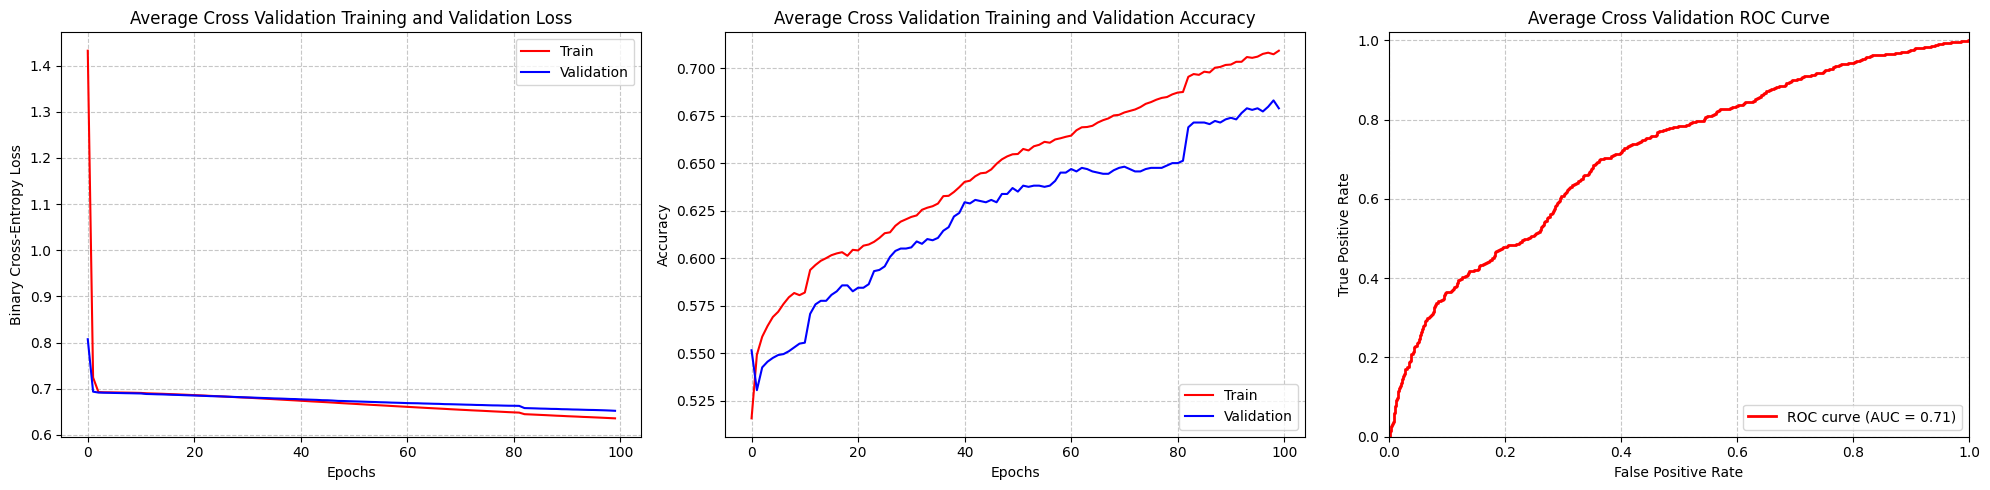

In [49]:
# Evaluating MLP 1
tf.keras.utils.set_random_seed(1)

data_train_bert_single.shape

# Perform cross-validation
mlp1_cv_results = cross_validate_model(
    data_train, 
    y_train,
    model_fn=MLP1,
    n_splits=5, 
    epochs=100, 
    batch_size=32,
    save_path='best_MLP1.weights.h5'
)

# Plot the cross-validation results showing the average training and validation metrics across all folds for each epoch
fig = plot_cross_validation_results(mlp1_cv_results)
plt.show()

Epoch 1/10


/Users/matthew/Projects/DeeplearningA2/A2/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/Users/matthew/Projects/DeeplearningA2/A2/lib/python3.12/site-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 10 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


126/126 ━━━━━━━━━━━━━━━━━━━━ 0s 620us/step - accuracy: 0.7031 - loss: 0.6354
Epoch 2/10
126/126 ━━━━━━━━━━━━━━━━━━━━ 0s 584us/step - accuracy: 0.6927 - loss: 0.6351
Epoch 3/10
126/126 ━━━━━━━━━━━━━━━━━━━━ 0s 541us/step - accuracy: 0.6948 - loss: 0.6366
Epoch 4/10
126/126 ━━━━━━━━━━━━━━━━━━━━ 0s 526us/step - accuracy: 0.6945 - loss: 0.6365
Epoch 5/10
126/126 ━━━━━━━━━━━━━━━━━━━━ 0s 542us/step - accuracy: 0.6958 - loss: 0.6359
Epoch 6/10
126/126 ━━━━━━━━━━━━━━━━━━━━ 0s 861us/step - accuracy: 0.6915 - loss: 0.6356
Epoch 7/10
126/126 ━━━━━━━━━━━━━━━━━━━━ 0s 577us/step - accuracy: 0.6929 - loss: 0.6350
Epoch 8/10
126/126 ━━━━━━━━━━━━━━━━━━━━ 0s 554us/step - accuracy: 0.6926 - loss: 0.6345
Epoch 9/10
126/126 ━━━━━━━━━━━━━━━━━━━━ 0s 552us/step - accuracy: 0.6923 - loss: 0.6341
Epoch 10/10
126/126 ━━━━━━━━━━━━━━━━━━━━ 0s 554us/step - accuracy: 0.6931 - loss: 0.6336
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6781 - loss: 0.6232 
Accuracy on test dataset: 0.64
Loss:  0.6565913558006287

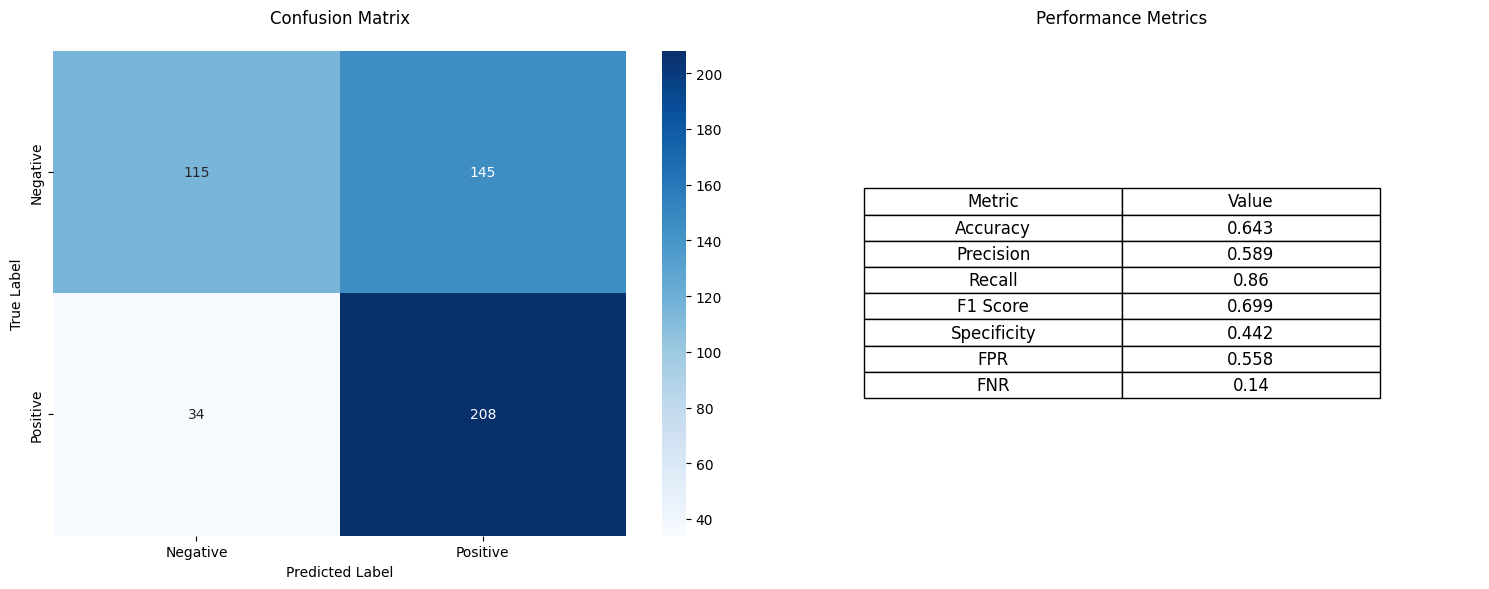

Accuracy: 0.643
Precision: 0.589
Recall: 0.860
F1 Score: 0.699
Specificity: 0.442
False Positive Rate: 0.558
False Negative Rate: 0.140


,Metric,Value
0,Accuracy,0.643
1,Precision,0.589
2,Recall,0.860
3,F1 Score,0.699
4,Specificity,0.442
5,FPR,0.558
6,FNR,0.140


In [50]:
# Testing MLP 1 On Truly Unseen Data

# Use the best model found accross all folds
final_model = MLP1(n_features=300)
final_model.load_weights('best_MLP1.weights.h5')


# Retrain the model on the full training set to learn remaining unseen patterns
history = final_model.fit(data_train, y_train, epochs=10, batch_size=16, verbose=1)


# Calculate Final accuracy & loss
loss, acc = final_model.evaluate(data_test, y_test)
print('Accuracy on test dataset: %.2f' % acc)
print('Loss: ', loss)

plot_final_results(final_model, data_test, y_test)

# Multi Layer Perceptron 2, Each review represented as a sequence of pre-trained word embedding vectors, leveraging the Keras Embedding layer.

In [9]:
#  MLP 2 Optimised Model
def MLP2():
    model = Sequential()
    model.add(Embedding(num_words, 300, weights=[embedding_matrix], input_length=max_length, trainable=True))
    model.add(Flatten())
    init_he_u = initializers.he_uniform(seed=None)
    model.add(Dense(24, activation='relu', kernel_initializer=init_he_u, kernel_regularizer=l2(0.06)))
    model.add(Dense(32, activation='relu', kernel_initializer=init_he_u, kernel_regularizer=l2(0.06)))
    model.add(Dense(1, activation='sigmoid'))
    opt = optimizers.Adam(learning_rate=0.0007)
    model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['acc'])
    return model

(2003, 87)
Epoch 1/100


/Users/matthew/Projects/DeeplearningA2/A2/lib/python3.12/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


51/51 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - acc: 0.6972 - loss: 5.3120 - val_acc: 0.8030 - val_loss: 3.6135
Epoch 2/100
51/51 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - acc: 0.8205 - loss: 3.4139 - val_acc: 0.8254 - val_loss: 2.9971
Epoch 3/100
51/51 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - acc: 0.9232 - loss: 2.7373 - val_acc: 0.8404 - val_loss: 2.4476
Epoch 4/100
51/51 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - acc: 0.9599 - loss: 2.2093 - val_acc: 0.8404 - val_loss: 2.0850
Epoch 5/100
51/51 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - acc: 0.9705 - loss: 1.7853 - val_acc: 0.8454 - val_loss: 1.7463
Epoch 6/100
51/51 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - acc: 0.9827 - loss: 1.4449 - val_acc: 0.8279 - val_loss: 1.5086
Epoch 7/100
51/51 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - acc: 0.9860 - loss: 1.1801 - val_acc: 0.7406 - val_loss: 1.3908
Epoch 8/100
51/51 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - acc: 0.9805 - loss: 0.9885 - val_acc: 0.7905 - val_loss: 1.1717
Epoch 9/100
51/51 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - acc: 0.9810 - 

/Users/matthew/Projects/DeeplearningA2/A2/lib/python3.12/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


51/51 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - acc: 0.7360 - loss: 5.3901 - val_acc: 0.8155 - val_loss: 3.6493
Epoch 2/100
51/51 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - acc: 0.8503 - loss: 3.4566 - val_acc: 0.8504 - val_loss: 3.0076
Epoch 3/100
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - acc: 0.9297 - loss: 2.7771 - val_acc: 0.8579 - val_loss: 2.4871
Epoch 4/100
51/51 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - acc: 0.9615 - loss: 2.2357 - val_acc: 0.8279 - val_loss: 2.0875
Epoch 5/100
51/51 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - acc: 0.9803 - loss: 1.8027 - val_acc: 0.8479 - val_loss: 1.7291
Epoch 6/100
51/51 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - acc: 0.9879 - loss: 1.4588 - val_acc: 0.8304 - val_loss: 1.4842
Epoch 7/100
51/51 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - acc: 0.9924 - loss: 1.1818 - val_acc: 0.8354 - val_loss: 1.2630
Epoch 8/100
51/51 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - acc: 0.9954 - loss: 0.9599 - val_acc: 0.8329 - val_loss: 1.0893
Epoch 9/100
51/51 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - acc: 0.9976 - l

/Users/matthew/Projects/DeeplearningA2/A2/lib/python3.12/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


51/51 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - acc: 0.7111 - loss: 5.3290 - val_acc: 0.7681 - val_loss: 3.6694
Epoch 2/100
51/51 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - acc: 0.8320 - loss: 3.4387 - val_acc: 0.8005 - val_loss: 3.0505
Epoch 3/100
51/51 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - acc: 0.9132 - loss: 2.7778 - val_acc: 0.8080 - val_loss: 2.5509
Epoch 4/100
51/51 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - acc: 0.9595 - loss: 2.2439 - val_acc: 0.8379 - val_loss: 2.1109
Epoch 5/100
51/51 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - acc: 0.9851 - loss: 1.8109 - val_acc: 0.8429 - val_loss: 1.7556
Epoch 6/100
51/51 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - acc: 0.9916 - loss: 1.4671 - val_acc: 0.8603 - val_loss: 1.4738
Epoch 7/100
51/51 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - acc: 0.9953 - loss: 1.1939 - val_acc: 0.8728 - val_loss: 1.2507
Epoch 8/100
51/51 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - acc: 0.9972 - loss: 0.9749 - val_acc: 0.8653 - val_loss: 1.0755
Epoch 9/100
51/51 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - acc: 0.9956 - 

/Users/matthew/Projects/DeeplearningA2/A2/lib/python3.12/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


51/51 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - acc: 0.7181 - loss: 5.2498 - val_acc: 0.8375 - val_loss: 3.5557
Epoch 2/100
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - acc: 0.8512 - loss: 3.3665 - val_acc: 0.8550 - val_loss: 2.9197
Epoch 3/100
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - acc: 0.9182 - loss: 2.7001 - val_acc: 0.8600 - val_loss: 2.4092
Epoch 4/100
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - acc: 0.9642 - loss: 2.1684 - val_acc: 0.8550 - val_loss: 2.0088
Epoch 5/100
51/51 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - acc: 0.9773 - loss: 1.7500 - val_acc: 0.8450 - val_loss: 1.6901
Epoch 6/100
51/51 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - acc: 0.9862 - loss: 1.4168 - val_acc: 0.8325 - val_loss: 1.4407
Epoch 7/100
51/51 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - acc: 0.9925 - loss: 1.1517 - val_acc: 0.8175 - val_loss: 1.2413
Epoch 8/100
51/51 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - acc: 0.9957 - loss: 0.9392 - val_acc: 0.8100 - val_loss: 1.0897
Epoch 9/100
51/51 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - acc: 0.9975 - los

/Users/matthew/Projects/DeeplearningA2/A2/lib/python3.12/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


51/51 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - acc: 0.7320 - loss: 5.4115 - val_acc: 0.7975 - val_loss: 3.7232
Epoch 2/100
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - acc: 0.8334 - loss: 3.5187 - val_acc: 0.8375 - val_loss: 3.0604
Epoch 3/100
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - acc: 0.9188 - loss: 2.8401 - val_acc: 0.8650 - val_loss: 2.5155
Epoch 4/100
51/51 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - acc: 0.9518 - loss: 2.2864 - val_acc: 0.8600 - val_loss: 2.0907
Epoch 5/100
51/51 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - acc: 0.9737 - loss: 1.8467 - val_acc: 0.8500 - val_loss: 1.7686
Epoch 6/100
51/51 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - acc: 0.9819 - loss: 1.4965 - val_acc: 0.7625 - val_loss: 1.6009
Epoch 7/100
51/51 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - acc: 0.9855 - loss: 1.2234 - val_acc: 0.8550 - val_loss: 1.2620
Epoch 8/100
51/51 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - acc: 0.9910 - loss: 1.0073 - val_acc: 0.8550 - val_loss: 1.0766
Epoch 9/100
51/51 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - acc: 0.9919 - lo

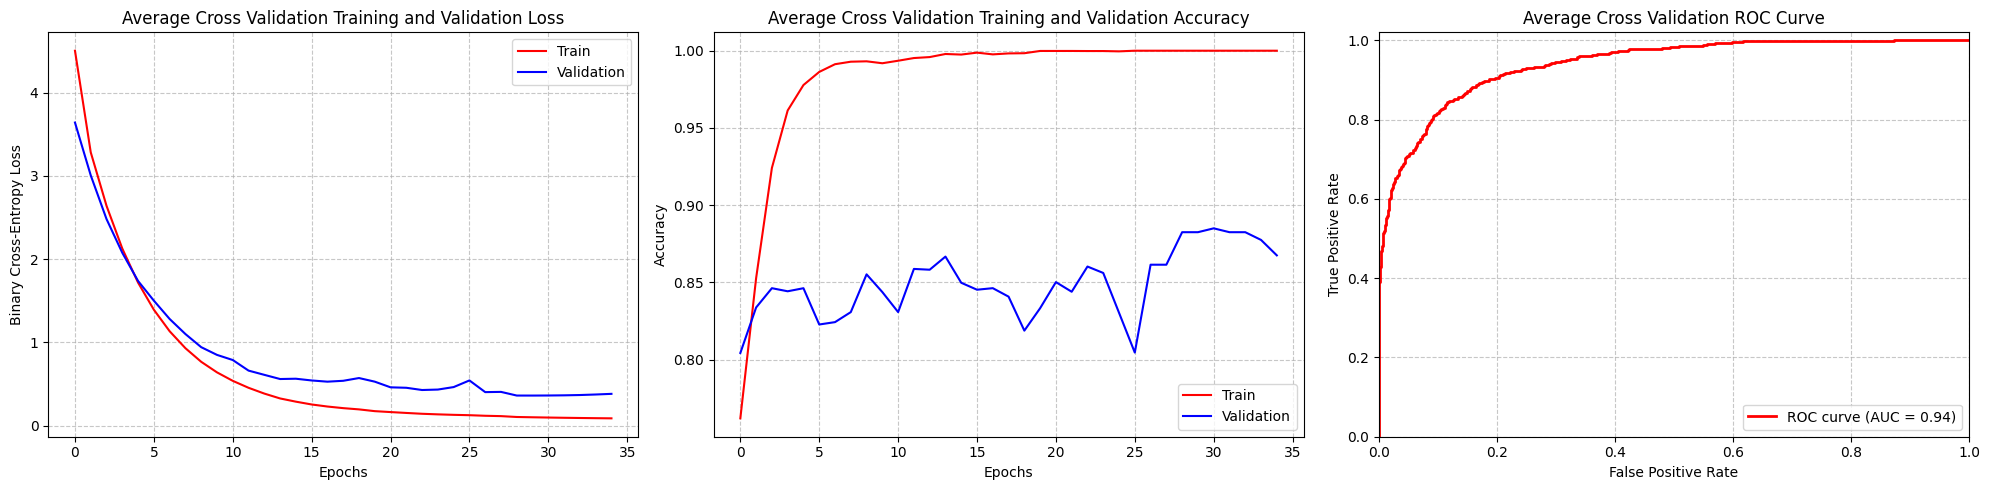

In [11]:
# Evaluating MLP 2
tf.keras.utils.set_random_seed(2)

print(x_train_seq.shape)

# Perform cross-validation
mlp2_cv_results = cross_validate_model(
    x_train_seq, 
    y_train,
    model_fn=MLP2,
    n_splits=5, 
    epochs=100, 
    batch_size=32,
    save_path='best_MLP2.weights.h5'
)

# Plot the cross-validation results showing the average training and validation metrics across all folds for each epoch
fig = plot_cross_validation_results(mlp2_cv_results)
plt.show()

Epoch 1/10


/Users/matthew/Projects/DeeplearningA2/A2/lib/python3.12/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(
/Users/matthew/Projects/DeeplearningA2/A2/lib/python3.12/site-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 16 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


126/126 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - acc: 0.9698 - loss: 0.1823
Epoch 2/10
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - acc: 0.9818 - loss: 0.1552
Epoch 3/10
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - acc: 0.9849 - loss: 0.1342
Epoch 4/10
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - acc: 0.9867 - loss: 0.1186
Epoch 5/10
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - acc: 0.9907 - loss: 0.1077
Epoch 6/10
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - acc: 0.9943 - loss: 0.0984
Epoch 7/10
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - acc: 0.9985 - loss: 0.0909
Epoch 8/10
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - acc: 0.9985 - loss: 0.0846
Epoch 9/10
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - acc: 0.9987 - loss: 0.0788
Epoch 10/10
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - acc: 0.9989 - loss: 0.0741
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - acc: 0.8697 - loss: 0.3189  
Accuracy on test dataset: 0.84
Loss:  0.37742215394973755
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


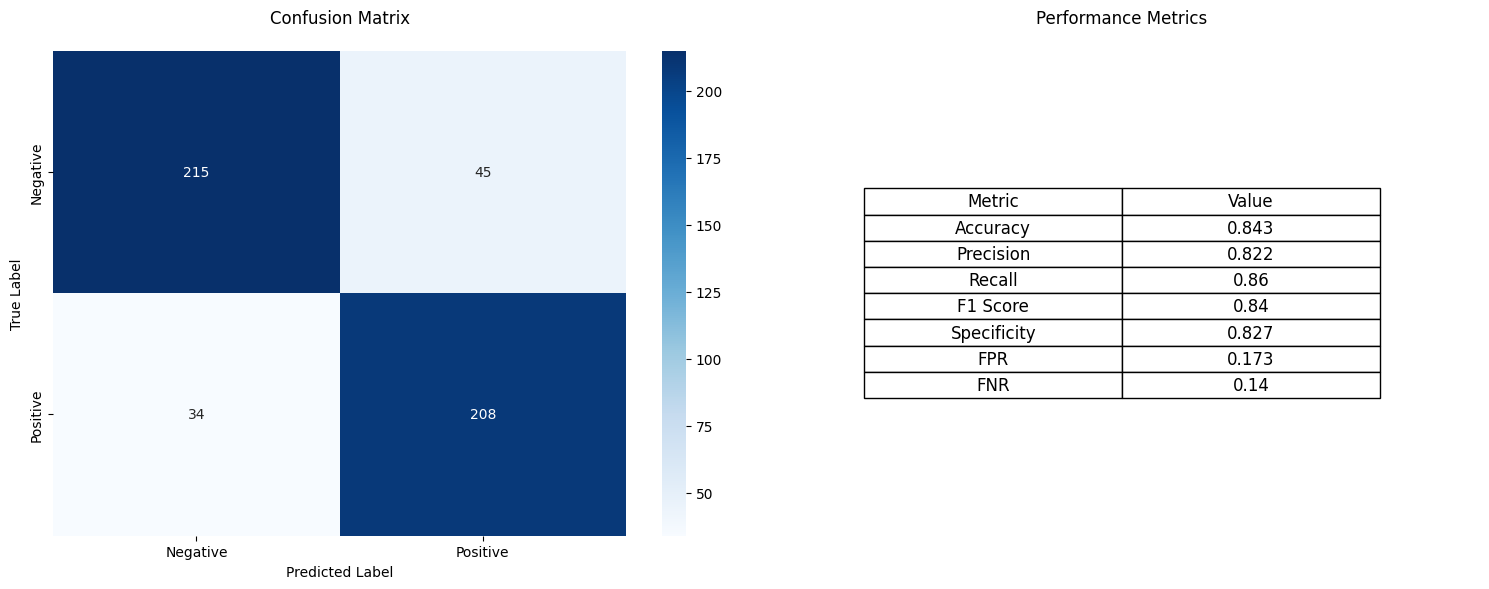

Accuracy: 0.843
Precision: 0.822
Recall: 0.860
F1 Score: 0.840
Specificity: 0.827
False Positive Rate: 0.173
False Negative Rate: 0.140


,Metric,Value
0,Accuracy,0.843
1,Precision,0.822
2,Recall,0.860
3,F1 Score,0.840
4,Specificity,0.827
5,FPR,0.173
6,FNR,0.140


In [ ]:
# Testing MLP 2 On Truly Unseen Data
tf.keras.utils.set_random_seed(1)
# Use the best model found accross all folds
final_model = MLP2()
dummy_input = np.zeros((1, 87))
_ = final_model(dummy_input)
# Verify model structure

final_model.load_weights('best_MLP2.weights.h5')

# Retrain the model on all training data using 10 epochs to learn final unseen patterns
history = final_model.fit(x_train_seq, y_train, epochs=10, batch_size=16, verbose=1)


# Evaluation and plotting remain the same
loss, acc = final_model.evaluate(x_test_seq, y_test)
print('Accuracy on test dataset: %.2f' % acc)
print('Loss: ', loss)

plot_final_results(final_model, x_test_seq, y_test)

# Convolutional Neural Network, Each review represented as a sequence of pre-trained word embedding vectors, leveraging the Keras Embedding layer.

In [ ]:
#  CNN Optimised Model
def modelCNN():
    model = Sequential()
    model.add(Embedding(num_words, 300, weights=[embedding_matrix], input_length=max_length, trainable=True))
    init_he_u = initializers.he_uniform(seed=None)
    model.add(Conv1D(128, 5, activation='relu', kernel_initializer=init_he_u, kernel_regularizer=l2(0.003)))
    model.add(Dropout(0.4))
    model.add(GlobalMaxPooling1D())
    model.add(Dense(16, activation='relu', kernel_initializer=init_he_u, kernel_regularizer=l2(0.003)))
    model.add(Dense(1, activation='sigmoid', kernel_initializer=init_he_u, kernel_regularizer=l2(0.003)))
    opt = optimizers.Adam(learning_rate=0.001)
    model.compile(loss='binary_crossentropy', optimizer=opt , metrics=['acc'])
    return model

Epoch 1/100


/Users/matthew/Projects/DeeplearningA2/A2/lib/python3.12/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


26/26 ━━━━━━━━━━━━━━━━━━━━ 2s 43ms/step - acc: 0.4797 - loss: 16.4492 - val_acc: 0.6733 - val_loss: 8.2642
Epoch 2/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step - acc: 0.6873 - loss: 6.5159 - val_acc: 0.5786 - val_loss: 2.5957
Epoch 3/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step - acc: 0.6500 - loss: 2.1092 - val_acc: 0.5287 - val_loss: 1.3839
Epoch 4/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step - acc: 0.6287 - loss: 1.3217 - val_acc: 0.5411 - val_loss: 1.1627
Epoch 5/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - acc: 0.6485 - loss: 1.1480 - val_acc: 0.5786 - val_loss: 1.0699
Epoch 6/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - acc: 0.6803 - loss: 1.0544 - val_acc: 0.6733 - val_loss: 0.9989
Epoch 7/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - acc: 0.7703 - loss: 0.9661 - val_acc: 0.7032 - val_loss: 0.9420
Epoch 8/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - acc: 0.8281 - loss: 0.8877 - val_acc: 0.7382 - val_loss: 0.9003
Epoch 9/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - acc: 0.8574 -

/Users/matthew/Projects/DeeplearningA2/A2/lib/python3.12/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


26/26 ━━━━━━━━━━━━━━━━━━━━ 2s 40ms/step - acc: 0.5440 - loss: 16.5934 - val_acc: 0.7531 - val_loss: 8.7208
Epoch 2/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - acc: 0.7560 - loss: 6.9579 - val_acc: 0.7182 - val_loss: 2.9580
Epoch 3/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - acc: 0.7768 - loss: 2.3581 - val_acc: 0.6309 - val_loss: 1.5048
Epoch 4/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - acc: 0.7343 - loss: 1.3866 - val_acc: 0.6284 - val_loss: 1.2388
Epoch 5/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - acc: 0.7554 - loss: 1.1869 - val_acc: 0.6958 - val_loss: 1.1368
Epoch 6/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step - acc: 0.8133 - loss: 1.0554 - val_acc: 0.7431 - val_loss: 1.0523
Epoch 7/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - acc: 0.8572 - loss: 0.9268 - val_acc: 0.7731 - val_loss: 0.9744
Epoch 8/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - acc: 0.9083 - loss: 0.7930 - val_acc: 0.7855 - val_loss: 0.9049
Epoch 9/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - acc: 0.9323 -

/Users/matthew/Projects/DeeplearningA2/A2/lib/python3.12/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


26/26 ━━━━━━━━━━━━━━━━━━━━ 2s 45ms/step - acc: 0.5983 - loss: 16.5102 - val_acc: 0.7232 - val_loss: 8.5896
Epoch 2/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step - acc: 0.7726 - loss: 6.8273 - val_acc: 0.7057 - val_loss: 2.9006
Epoch 3/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - acc: 0.7802 - loss: 2.3016 - val_acc: 0.6808 - val_loss: 1.4818
Epoch 4/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step - acc: 0.8173 - loss: 1.3384 - val_acc: 0.6858 - val_loss: 1.2122
Epoch 5/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step - acc: 0.8325 - loss: 1.1266 - val_acc: 0.7207 - val_loss: 1.1086
Epoch 6/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step - acc: 0.8731 - loss: 0.9801 - val_acc: 0.7656 - val_loss: 1.0286
Epoch 7/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - acc: 0.8881 - loss: 0.8494 - val_acc: 0.7805 - val_loss: 0.9606
Epoch 8/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - acc: 0.9198 - loss: 0.7238 - val_acc: 0.7731 - val_loss: 0.9007
Epoch 9/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - acc: 0.9253 -

/Users/matthew/Projects/DeeplearningA2/A2/lib/python3.12/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


26/26 ━━━━━━━━━━━━━━━━━━━━ 2s 40ms/step - acc: 0.5797 - loss: 16.5728 - val_acc: 0.7325 - val_loss: 8.8391
Epoch 2/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step - acc: 0.7810 - loss: 7.1240 - val_acc: 0.7300 - val_loss: 3.2269
Epoch 3/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - acc: 0.7828 - loss: 2.5685 - val_acc: 0.7700 - val_loss: 1.6189
Epoch 4/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step - acc: 0.8206 - loss: 1.4623 - val_acc: 0.7750 - val_loss: 1.2906
Epoch 5/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step - acc: 0.8442 - loss: 1.1878 - val_acc: 0.7875 - val_loss: 1.1734
Epoch 6/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step - acc: 0.8748 - loss: 1.0515 - val_acc: 0.7725 - val_loss: 1.0811
Epoch 7/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step - acc: 0.9002 - loss: 0.9076 - val_acc: 0.7875 - val_loss: 0.9967
Epoch 8/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - acc: 0.9320 - loss: 0.7816 - val_acc: 0.8025 - val_loss: 0.9336
Epoch 9/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - acc: 0.9467 -

/Users/matthew/Projects/DeeplearningA2/A2/lib/python3.12/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


26/26 ━━━━━━━━━━━━━━━━━━━━ 2s 42ms/step - acc: 0.5698 - loss: 16.5403 - val_acc: 0.7575 - val_loss: 8.7894
Epoch 2/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - acc: 0.7905 - loss: 7.0347 - val_acc: 0.7700 - val_loss: 3.1223
Epoch 3/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - acc: 0.8204 - loss: 2.4866 - val_acc: 0.7550 - val_loss: 1.6031
Epoch 4/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - acc: 0.8554 - loss: 1.4279 - val_acc: 0.7750 - val_loss: 1.2817
Epoch 5/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - acc: 0.8620 - loss: 1.1588 - val_acc: 0.7900 - val_loss: 1.1612
Epoch 6/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - acc: 0.8991 - loss: 1.0089 - val_acc: 0.8100 - val_loss: 1.0664
Epoch 7/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - acc: 0.9135 - loss: 0.8598 - val_acc: 0.8000 - val_loss: 0.9874
Epoch 8/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step - acc: 0.9259 - loss: 0.7432 - val_acc: 0.7875 - val_loss: 0.9330
Epoch 9/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step - acc: 0.9428 -

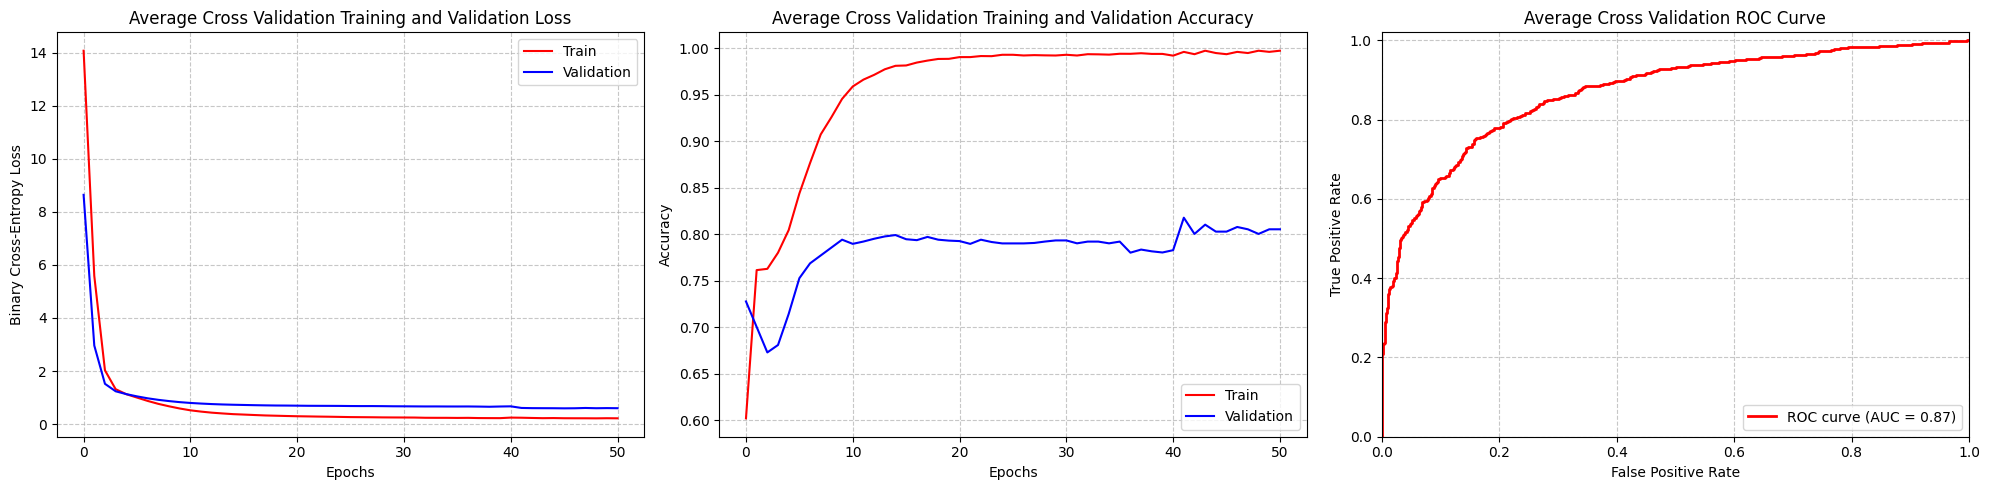

In [64]:
# Evaluating CNN
tf.keras.utils.set_random_seed(1)

# Perform cross-validation
cnn_cv_results = cross_validate_model(
    x_train_seq, 
    y_train,
    model_fn=modelCNN,
    n_splits=5, 
    epochs=100, 
    batch_size=64,
    save_path='best_CNN.weights.h5'
)

fig = plot_cross_validation_results(cnn_cv_results)
plt.show()

Epoch 1/10


/Users/matthew/Projects/DeeplearningA2/A2/lib/python3.12/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(
/Users/matthew/Projects/DeeplearningA2/A2/lib/python3.12/site-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 16 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step - acc: 0.9563 - loss: 0.4201
Epoch 2/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - acc: 0.9588 - loss: 0.3325
Epoch 3/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - acc: 0.9726 - loss: 0.3087
Epoch 4/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - acc: 0.9864 - loss: 0.2833
Epoch 5/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - acc: 0.9862 - loss: 0.2669
Epoch 6/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - acc: 0.9874 - loss: 0.2588
Epoch 7/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - acc: 0.9888 - loss: 0.2585
Epoch 8/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - acc: 0.9860 - loss: 0.2485
Epoch 9/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - acc: 0.9916 - loss: 0.2404
Epoch 10/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - acc: 0.9934 - loss: 0.2362
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - acc: 0.8599 - loss: 0.5368
Accuracy on test dataset: 0.82
Loss:  0.5994677543640137
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step


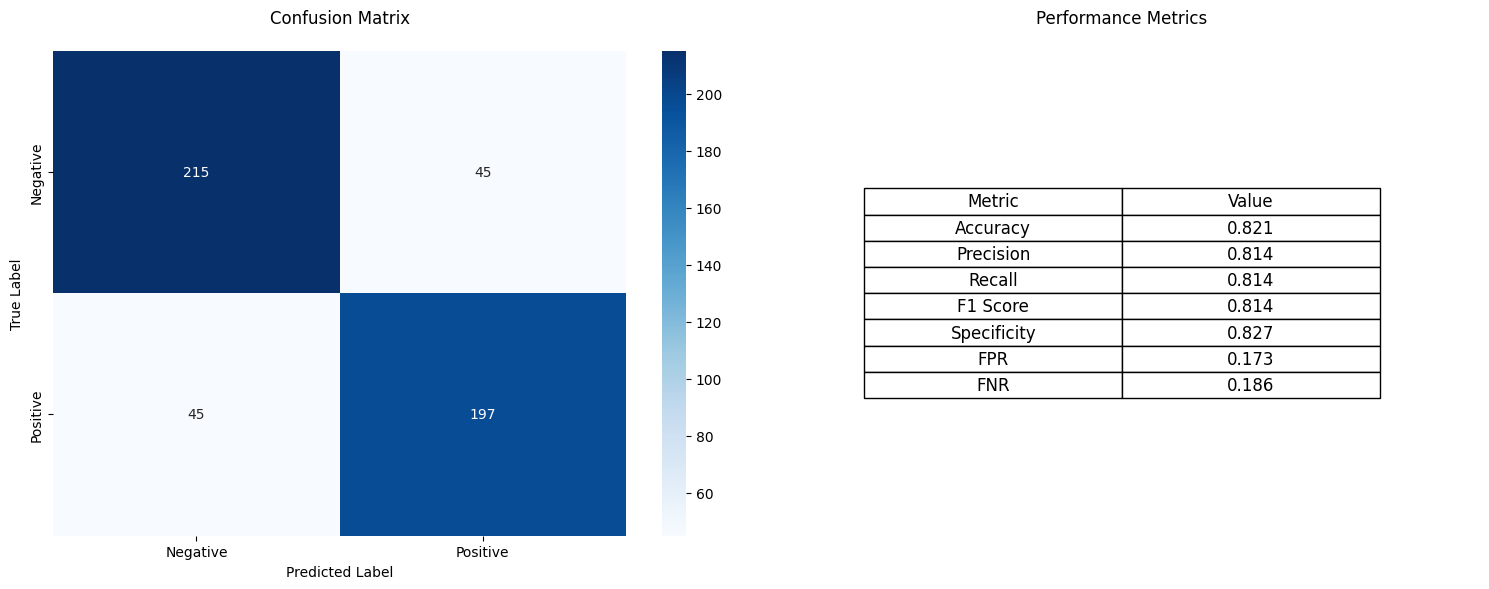

Accuracy: 0.821
Precision: 0.814
Recall: 0.814
F1 Score: 0.814
Specificity: 0.827
False Positive Rate: 0.173
False Negative Rate: 0.186


,Metric,Value
0,Accuracy,0.821
1,Precision,0.814
2,Recall,0.814
3,F1 Score,0.814
4,Specificity,0.827
5,FPR,0.173
6,FNR,0.186


In [ ]:
# Testing CNN On Truly Unseen Data

# Use the best model found accross all folds
final_model = modelCNN()
dummy_input = np.zeros((1, 87))
_ = final_model(dummy_input)
final_model.load_weights('best_CNN.weights.h5')

# Retrain the model on the full training set so it can learn some remaining patterns
history = final_model.fit( x_train_seq, y_train, epochs=10, batch_size=32, verbose=1)


# Calculate Final accuracy & loss
loss, acc = final_model.evaluate(x_test_seq, y_test)
print('Accuracy on test dataset: %.2f' % acc)
print('Loss: ', loss)

plot_final_results(final_model, x_test_seq, y_test)

# Recurrent Neural Network, Each review represented as a sequence of pre-trained word embedding vectors, leveraging the Keras Embedding layer.

In [ ]:
# RNN optimal model & BERT model
def RNNOPT():
    model = Sequential()
    model.add(Embedding(num_words, output_dim=300, weights=[embedding_matrix], input_length=87, trainable=True, mask_zero = True))
    init_he_u = initializers.he_uniform(seed=None)
    model.add(LSTM(128, dropout=0.1, recurrent_dropout=0.1, kernel_initializer=init_he_u, kernel_regularizer=l2(0.01)))
    model.add(Dense(128, activation='relu', kernel_initializer=init_he_u, kernel_regularizer=l2(0.01)))
    model.add(Dense(1, activation='sigmoid', kernel_initializer=init_he_u, kernel_regularizer=l2(0.01)))
    opt = optimizers.Adam(learning_rate=0.001)
    model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['acc'])
    return model

def RNNBERTOPT():
    model = Sequential()
    model.add(Embedding(input_dim=vocab_size, output_dim=768, weights=[bert_embedding_matrix], input_length=87, trainable=True, mask_zero = True))
    init_he_u = initializers.he_uniform(seed=None)
    model.add(LSTM(128, dropout=0.1, recurrent_dropout=0.1, kernel_initializer=init_he_u, kernel_regularizer=l2(0.01)))
    model.add(Dense(128, activation='relu', kernel_initializer=init_he_u, kernel_regularizer=l2(0.01)))
    model.add(Dense(1, activation='sigmoid', kernel_initializer=init_he_u, kernel_regularizer=l2(0.01)))
    opt = optimizers.Adam(learning_rate=0.001)
    model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['acc'])
    return model

/Users/matthew/Projects/DeeplearningA2/A2/lib/python3.12/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Epoch 1/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 16s 441ms/step - acc: 0.6499 - loss: 11.5262 - val_acc: 0.7481 - val_loss: 6.6098
Epoch 2/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 11s 442ms/step - acc: 0.8077 - loss: 5.7154 - val_acc: 0.8653 - val_loss: 3.5605
Epoch 3/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 12s 452ms/step - acc: 0.8994 - loss: 3.0851 - val_acc: 0.9127 - val_loss: 2.1507
Epoch 4/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 12s 457ms/step - acc: 0.9283 - loss: 1.8852 - val_acc: 0.8878 - val_loss: 1.5172
Epoch 5/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 12s 450ms/step - acc: 0.9483 - loss: 1.2830 - val_acc: 0.8803 - val_loss: 1.1738
Epoch 6/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 12s 450ms/step - acc: 0.9541 - loss: 0.9751 - val_acc: 0.9152 - val_loss: 0.8982
Epoch 7/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 12s 469ms/step - acc: 0.9757 - loss: 0.7192 - val_acc: 0.9027 - val_loss: 0.7609
Epoch 8/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 12s 458ms/step - acc: 0.9807 - loss: 0.5546 - val_acc: 0.9027 - val_loss: 0.6353
Epoch 9/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 

/Users/matthew/Projects/DeeplearningA2/A2/lib/python3.12/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


26/26 ━━━━━━━━━━━━━━━━━━━━ 15s 464ms/step - acc: 0.6503 - loss: 11.4765 - val_acc: 0.8304 - val_loss: 6.5923
Epoch 2/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 12s 470ms/step - acc: 0.8216 - loss: 5.6988 - val_acc: 0.8529 - val_loss: 3.5559
Epoch 3/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 12s 456ms/step - acc: 0.8840 - loss: 3.1027 - val_acc: 0.7805 - val_loss: 2.3628
Epoch 4/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 12s 469ms/step - acc: 0.8971 - loss: 1.9569 - val_acc: 0.9152 - val_loss: 1.4531
Epoch 5/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 12s 462ms/step - acc: 0.9585 - loss: 1.2940 - val_acc: 0.9327 - val_loss: 1.0952
Epoch 6/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 12s 475ms/step - acc: 0.9763 - loss: 0.9207 - val_acc: 0.8778 - val_loss: 0.9671
Epoch 7/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 12s 466ms/step - acc: 0.9720 - loss: 0.7359 - val_acc: 0.8678 - val_loss: 0.9526
Epoch 8/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 13s 484ms/step - acc: 0.9682 - loss: 0.6125 - val_acc: 0.9177 - val_loss: 0.6636
Epoch 9/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 12s 477ms/st

/Users/matthew/Projects/DeeplearningA2/A2/lib/python3.12/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


26/26 ━━━━━━━━━━━━━━━━━━━━ 15s 453ms/step - acc: 0.6506 - loss: 11.5230 - val_acc: 0.8105 - val_loss: 6.6454
Epoch 2/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 12s 460ms/step - acc: 0.8128 - loss: 5.7329 - val_acc: 0.8579 - val_loss: 3.5619
Epoch 3/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 12s 477ms/step - acc: 0.8932 - loss: 3.1200 - val_acc: 0.6908 - val_loss: 2.6176
Epoch 4/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 12s 472ms/step - acc: 0.8591 - loss: 2.0705 - val_acc: 0.8204 - val_loss: 1.7237
Epoch 5/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 12s 452ms/step - acc: 0.9222 - loss: 1.3995 - val_acc: 0.8579 - val_loss: 1.3291
Epoch 6/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 12s 464ms/step - acc: 0.9587 - loss: 1.0201 - val_acc: 0.8778 - val_loss: 1.0680
Epoch 7/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 12s 464ms/step - acc: 0.9730 - loss: 0.7697 - val_acc: 0.8853 - val_loss: 0.8914
Epoch 8/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 13s 503ms/step - acc: 0.9912 - loss: 0.5904 - val_acc: 0.8579 - val_loss: 0.8851
Epoch 9/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 12s 462ms/st

/Users/matthew/Projects/DeeplearningA2/A2/lib/python3.12/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Epoch 1/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 14s 441ms/step - acc: 0.6351 - loss: 11.5429 - val_acc: 0.7375 - val_loss: 6.8086
Epoch 2/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 12s 468ms/step - acc: 0.7976 - loss: 5.7759 - val_acc: 0.8425 - val_loss: 3.5090
Epoch 3/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 13s 502ms/step - acc: 0.8789 - loss: 3.0496 - val_acc: 0.9175 - val_loss: 2.0226
Epoch 4/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 13s 489ms/step - acc: 0.9338 - loss: 1.8093 - val_acc: 0.8925 - val_loss: 1.4123
Epoch 5/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 15s 566ms/step - acc: 0.9536 - loss: 1.2250 - val_acc: 0.8700 - val_loss: 1.1763
Epoch 6/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 12s 476ms/step - acc: 0.9534 - loss: 0.9315 - val_acc: 0.9025 - val_loss: 0.9028
Epoch 7/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 12s 472ms/step - acc: 0.9625 - loss: 0.6979 - val_acc: 0.9200 - val_loss: 0.7145
Epoch 8/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 12s 467ms/step - acc: 0.9871 - loss: 0.5298 - val_acc: 0.9175 - val_loss: 0.6009
Epoch 9/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 

/Users/matthew/Projects/DeeplearningA2/A2/lib/python3.12/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


26/26 ━━━━━━━━━━━━━━━━━━━━ 15s 460ms/step - acc: 0.5964 - loss: 11.5768 - val_acc: 0.7425 - val_loss: 6.8527
Epoch 2/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 13s 501ms/step - acc: 0.7964 - loss: 5.8280 - val_acc: 0.8150 - val_loss: 3.5891
Epoch 3/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 13s 489ms/step - acc: 0.8831 - loss: 3.0599 - val_acc: 0.8625 - val_loss: 2.1570
Epoch 4/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 12s 464ms/step - acc: 0.9045 - loss: 1.8839 - val_acc: 0.8025 - val_loss: 1.6801
Epoch 5/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 13s 495ms/step - acc: 0.9292 - loss: 1.3148 - val_acc: 0.8700 - val_loss: 1.1760
Epoch 6/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 14s 521ms/step - acc: 0.9619 - loss: 0.9445 - val_acc: 0.8825 - val_loss: 1.0002
Epoch 7/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 13s 482ms/step - acc: 0.9762 - loss: 0.7057 - val_acc: 0.9100 - val_loss: 0.7845
Epoch 8/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 12s 469ms/step - acc: 0.9852 - loss: 0.5377 - val_acc: 0.8925 - val_loss: 0.7142
Epoch 9/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 12s 460ms/st

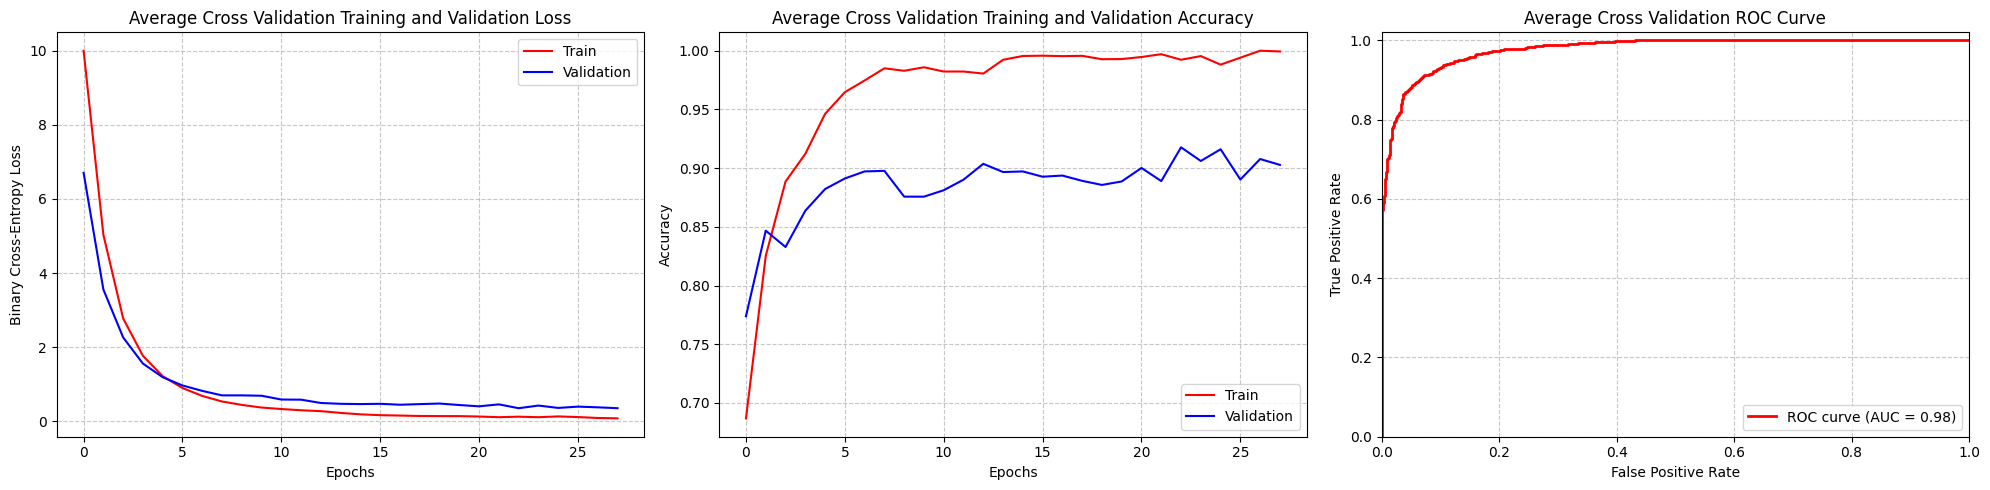

In [124]:
# Evaluating RNN

# Evaluating CNN
tf.keras.utils.set_random_seed(1)

# Perform cross-validation
rnn_cv_results = cross_validate_model(
    x_train_seq_bert, 
    y_train,
    model_fn=RNNBERTOPT,
    n_splits=5, 
    epochs=100, 
    batch_size=64,
    save_path='best_RNN_bert.weights.h5'
)

fig = plot_cross_validation_results(rnn_cv_results)
plt.show()

/Users/matthew/Projects/DeeplearningA2/A2/lib/python3.12/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(
/Users/matthew/Projects/DeeplearningA2/A2/lib/python3.12/site-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 18 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 71ms/step - acc: 0.9149 - loss: 0.3750
Accuracy on test dataset: 0.90
Loss:  0.4234852194786072
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 73ms/step


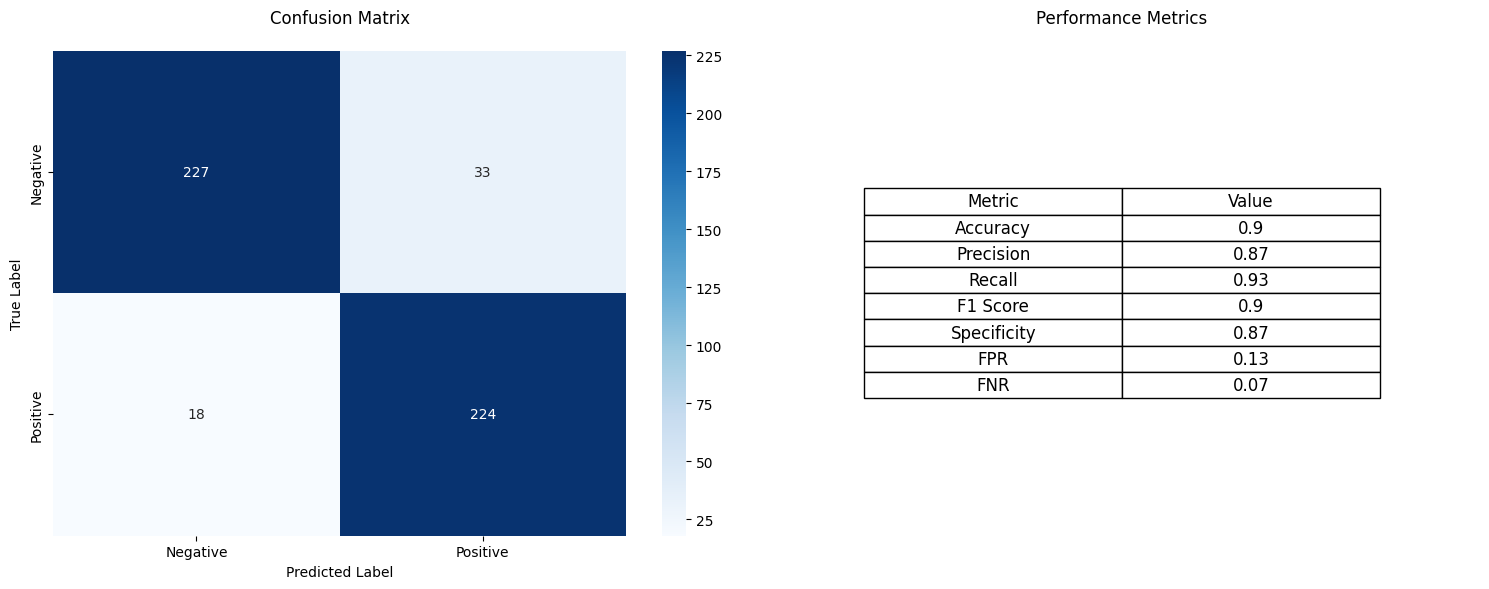

Accuracy: 0.90
Precision: 0.87
Recall: 0.93
F1 Score: 0.90
Specificity: 0.87
False Positive Rate: 0.13
False Negative Rate: 0.07


,Metric,Value
0,Accuracy,0.90
1,Precision,0.87
2,Recall,0.93
3,F1 Score,0.90
4,Specificity,0.87
5,FPR,0.13
6,FNR,0.07


In [ ]:
# Testing RNN on truly unseen data
final_model = RNNBERTOPT()
dummy_input = np.zeros((1, 87))
_ = final_model(dummy_input)
final_model.load_weights('best_RNN_bert.weights.h5')


# Calculate Final accuracy & loss
loss, acc = final_model.evaluate(x_test_seq_bert, y_test)
print('Accuracy on test dataset: %.2f' % acc)
print('Loss: ', loss)

plot_final_results(final_model, x_test_seq_bert, y_test)

# Task 2 - Optimisation intermediate Results before final optimal model (Not required for submission just used to generate intermediate graphs)

# Helper Functions

In [28]:
# Cross validation Function
def cross_validate_model_MLP1(X_train, y_train, model_fn, n_splits, epochs, batch_size, random_state=1):
    """Perform cross-validation and return results and training history."""
    # Set random seed for reproducibility
    tf.keras.utils.set_random_seed(random_state)
    
    # Initialize cross-validation
    skf = StratifiedKFold(n_splits=n_splits, shuffle=True)
    val_acc = []
    val_loss = []
    all_histories = []

    # For ROC curve
    all_val_labels = []
    all_val_preds = []

    # Track best model
    best_val_metric = float('inf')
    
    for fold, (train_idx, val_idx) in enumerate(skf.split(X_train, y_train)):
        # Get data for this fold
        X_train_fold, X_val_fold = X_train[train_idx], X_train[val_idx]
        y_train_fold, y_val_fold = y_train[train_idx], y_train[val_idx]
        
        # Create model for this fold
        fold_model = model_fn()

        early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
                
        # Train model
        history = fold_model.fit(X_train_fold, y_train_fold, epochs=epochs, batch_size=batch_size, validation_data=(X_val_fold, y_val_fold), callbacks=[early_stopping], verbose=1)
        
        # Save training history
        all_histories.append(history.history)

        # Get predictions for ROC curve
        y_val_pred = fold_model.predict(X_val_fold, verbose=0)

        # Store validation labels and predictions
        all_val_labels.extend(y_val_fold)
        all_val_preds.extend(y_val_pred)

        # storing metrics from this fold
        best_epoch_idx = np.argmin(history.history['val_loss'])
        fold_val_loss = history.history['val_loss'][best_epoch_idx]
        val_loss.append(history.history['val_loss'][best_epoch_idx])
        val_acc_key = 'val_accuracy' if 'val_accuracy' in history.history else 'val_acc'
        val_acc.append(history.history[val_acc_key][best_epoch_idx])

        # Check if this is the best model so far
        if fold_val_loss < best_val_metric:  # Using val_loss as metric
        # Alternative: if fold_val_acc > best_val_metric:  # Using val_acc as metric
            best_val_metric = fold_val_loss
            best_model = fold_model
            print(f"New best model found in fold {fold+1}")

        print("Cross Validation Results - Final metrics of fold")
        print(f" 'val_acc: ' {(history.history[val_acc_key][best_epoch_idx])}")
        print(f" 'val_loss: ' {(history.history['val_loss'][best_epoch_idx])}")
        print(f" 'Best epoch for this fold: ' {best_epoch_idx}")
    
    # Calculate mean values
    mean_val_acc = sum(val_acc) / len(val_acc)
    mean_val_loss = sum(val_loss) / len(val_loss)

    print("Average Cross Validation Results")
    print(f" 'mean_val_acc: ' {mean_val_acc}")
    print(f" 'mean_val_loss: ' {mean_val_loss}")

    # Convert lists to arrays for ROC curve calculation
    all_val_labels = np.array(all_val_labels)
    all_val_preds = np.array(all_val_preds)

    return {
        'val_acc': val_acc,
        'val_loss': val_loss,
        'mean_val_acc': mean_val_acc,
        'mean_val_loss': mean_val_loss,
        'histories': all_histories,
        'val_labels': all_val_labels,
        'val_preds': all_val_preds,
    }

In [29]:
# Function for plotting cross validation results

# Function for plotting cross validation results with loss, accuracy & ROC curves
def plot_cross_validation_results_MLP1(cv_results):
    """
    Visualize cross-validation results with three plots: loss curves, accuracy curves, and ROC curve
    
    Parameters:
    -----------
    cv_results : dict
        Dictionary containing cross-validation results from cross_validate_model function
    epochs : int
        Number of epochs used for training
    y_test : array-like
        True labels for test data
    y_pred_prob : array-like
        Prediction probabilities for test data
    """
    # Extract data from cv_results
    histories = cv_results['histories']
    val_labels = cv_results['val_labels']
    val_preds = cv_results['val_preds']
    
    # Prepare data for plotting
    max_epochs = max([len(history.get('loss', [])) for history in histories])
    z = np.arange(max_epochs)
    
    # Calculate average training and validation curves
    train_E_avg = np.zeros(max_epochs)
    test_E_avg = np.zeros(max_epochs)
    train_Acc_avg = np.zeros(max_epochs)
    test_Acc_avg = np.zeros(max_epochs)
    
    # Count for averaging
    counts = np.zeros(max_epochs)
    
    # Compute average curves
    for history in histories:
        hist_epochs = len(history['loss'])
        train_E_avg[:hist_epochs] += np.array(history['loss'])
        test_E_avg[:hist_epochs] += np.array(history['val_loss'])
        
        acc_key = 'accuracy' if 'accuracy' in history else 'acc'
        val_acc_key = 'val_accuracy' if 'val_accuracy' in history else 'val_acc'
        
        train_Acc_avg[:hist_epochs] += np.array(history[acc_key])
        test_Acc_avg[:hist_epochs] += np.array(history[val_acc_key])
        counts[:hist_epochs] += 1
    
    # Avoid division by zero
    counts = np.maximum(counts, 1)
    train_E_avg /= counts
    test_E_avg /= counts
    train_Acc_avg /= counts
    test_Acc_avg /= counts
    
    # Create figure with subplots
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(13, 5))
    # fig.suptitle('Model Curves', fontsize=16)
    
    # 1. Binary Cross-Entropy Loss
    ax1.plot(z, train_E_avg, label="Train", color='red')
    ax1.plot(z, test_E_avg, label="Validation", color='blue')
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('Binary Cross-Entropy Loss')
    ax1.set_title('Average Cross Validation Training and Validation Loss')
    ax1.legend(loc='upper right')
    ax1.grid(True, linestyle='--', alpha=0.7)
    
    # 2. Training Accuracy
    ax2.plot(z, train_Acc_avg, label="Train", color='red')
    ax2.plot(z, test_Acc_avg, label="Validation", color='blue')
    ax2.set_xlabel('Epochs')
    ax2.set_ylabel('Accuracy')
    ax2.set_title('Average Cross Validation Training and Validation Accuracy')
    ax2.legend(loc='lower right')
    ax2.grid(True, linestyle='--', alpha=0.7)
    
    # 3. ROC Curve
    # from sklearn.metrics import roc_curve, auc
    # fpr, tpr, _ = roc_curve(val_labels, val_preds)
    # roc_auc = auc(fpr, tpr)
    # ax3.plot(fpr, tpr, color='red', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
    # ax3.set_xlim([0.0, 1.0])
    # ax3.set_ylim([0.0, 1.02])
    # ax3.set_xlabel('False Positive Rate')
    # ax3.set_ylabel('True Positive Rate')
    # ax3.set_title('Average Cross Validation ROC Curve')
    # ax3.legend(loc="lower right")
    # ax3.grid(True, linestyle='--', alpha=0.7)
    
    plt.tight_layout()
    # plt.show()
    
    return fig

# MLP Single vector

In [187]:
#  All MLP 1 models
def MLP1BASE(n_features=300):
    model = Sequential()
    model.add(Dense(5, input_dim=n_features, activation='relu',  bias_initializer='zeros'))
    model.add(Dense(1, activation='sigmoid'))
    model.compile( loss='binary_crossentropy', metrics=['accuracy'])
    return model

def MLP1EARLYSTOP(n_features=300):
    model = Sequential()
    model.add(Dense(5, input_dim=n_features, activation='relu', bias_initializer='zeros'))
    model.add(Dense(1, activation='sigmoid'))
    model.compile( loss='binary_crossentropy', metrics=['accuracy'])
    return model

def MLP1REG(n_features=300):
    model = Sequential()
    model.add(Dense(5, input_dim=n_features, activation='relu', kernel_regularizer=l2(0.06), bias_initializer='zeros'))
    model.add(Dense(1, activation='sigmoid'))
    model.compile( loss='binary_crossentropy', metrics=['accuracy'])
    return model

def MLP1HE(n_features=300):
    model = Sequential()
    init_he_u = initializers.he_uniform(seed=None)
    model.add(Dense(5, input_dim=n_features, activation='relu', kernel_regularizer=l2(0.06), kernel_initializer=init_he_u, bias_initializer='zeros'))
    model.add(Dense(1, activation='sigmoid', kernel_initializer=init_he_u))
    model.compile( loss='binary_crossentropy', metrics=['accuracy'])
    return model

# def MLP1LAYERS(n_features=300):
#     model = Sequential()
#     init_he_u = initializers.he_uniform(seed=None)
#     model.add(Dense(32, input_dim=n_features, activation='relu', kernel_regularizer=l2(0.06), bias_initializer='zeros'))
#     model.add(Dense(1, activation='sigmoid'))
#     model.compile(loss='binary_crossentropy', metrics=['accuracy'])
#     return model

def MLP1ADAMHE(n_features=300):
    model = Sequential()
    init_he_u = initializers.he_uniform(seed=None)
    model.add(Dense(16, input_dim=n_features, activation='relu', kernel_regularizer=l2(0.06), kernel_initializer=init_he_u, bias_initializer='zeros'))
    model.add(Dense(1, activation='sigmoid', kernel_initializer=init_he_u))
    opt = optimizers.Adam(learning_rate=0.002)
    model.compile(optimizer=opt,loss='binary_crossentropy', metrics=['accuracy'])
    return model

# def MLP1ADAMHEHYPER(n_features=300):
#     model = Sequential()
#     init_he_u = initializers.he_uniform(seed=None)
#     model.add(Dense(32, input_dim=n_features, activation='relu', kernel_initializer=init_he_u, kernel_regularizer=l2(0.06), bias_initializer='zeros'))
#     model.add(Dense(24, activation='relu', kernel_initializer=init_he_u, kernel_regularizer=l2(0.06), bias_initializer='zeros'))
#     model.add(Dense(1, activation='sigmoid', kernel_initializer=init_he_u))
#     opt = optimizers.Adam(learning_rate=0.0007)
#     model.compile(optimizer=opt,loss='binary_crossentropy', metrics=['accuracy'])
#     return model

# MLP1 OPT 1
# def MLP1(n_features=300):
#     model = Sequential()
#     init_he_u = initializers.he_uniform(seed=None)
#     model.add(Dense(32, input_dim=n_features, activation='relu', kernel_initializer=init_he_u, kernel_regularizer=l2(0.08), bias_initializer='zeros'))
#     model.add(Dense(24, activation='relu', kernel_initializer=init_he_u, kernel_regularizer=l2(0.08), bias_initializer='zeros'))
#     model.add(Dense(1, activation='sigmoid'))
#     opt = optimizers.Adam(learning_rate=0.0007)
#     model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])
#     return model

Epoch 1/500


/Users/matthew/Projects/DeeplearningA2/A2/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


51/51 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.5261 - loss: 1.8821 - val_accuracy: 0.5262 - val_loss: 0.8057
Epoch 2/500
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5205 - loss: 0.7526 - val_accuracy: 0.5162 - val_loss: 0.6931
Epoch 3/500
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5119 - loss: 0.6940 - val_accuracy: 0.5212 - val_loss: 0.6912
Epoch 4/500
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5290 - loss: 0.6932 - val_accuracy: 0.5312 - val_loss: 0.6908
Epoch 5/500
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5431 - loss: 0.6931 - val_accuracy: 0.5312 - val_loss: 0.6907
Epoch 6/500
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5519 - loss: 0.6932 - val_accuracy: 0.5312 - val_loss: 0.6905
Epoch 7/500
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5662 - loss: 0.6933 - val_accuracy: 0.5312 - val_loss: 0.6901
Epoch 8/500
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5702 - loss: 0.6930 - val_accuracy: 0.5362 - val_loss: 0.6

/Users/matthew/Projects/DeeplearningA2/A2/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


51/51 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.4430 - loss: 1.9062 - val_accuracy: 0.5561 - val_loss: 0.8070
Epoch 2/500
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5134 - loss: 0.7522 - val_accuracy: 0.5810 - val_loss: 0.6938
Epoch 3/500
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5236 - loss: 0.6934 - val_accuracy: 0.5885 - val_loss: 0.6917
Epoch 4/500
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5433 - loss: 0.6925 - val_accuracy: 0.6035 - val_loss: 0.6914
Epoch 5/500
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5431 - loss: 0.6923 - val_accuracy: 0.6035 - val_loss: 0.6911
Epoch 6/500
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5564 - loss: 0.6922 - val_accuracy: 0.5960 - val_loss: 0.6909
Epoch 7/500
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5744 - loss: 0.6919 - val_accuracy: 0.5985 - val_loss: 0.6905
Epoch 8/500
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5755 - loss: 0.6918 - val_accuracy: 0.5985 - val_loss: 0.6

/Users/matthew/Projects/DeeplearningA2/A2/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


51/51 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.5370 - loss: 1.8943 - val_accuracy: 0.6060 - val_loss: 0.8060
Epoch 2/500
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5619 - loss: 0.7521 - val_accuracy: 0.5636 - val_loss: 0.6927
Epoch 3/500
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5542 - loss: 0.6933 - val_accuracy: 0.5810 - val_loss: 0.6907
Epoch 4/500
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5629 - loss: 0.6925 - val_accuracy: 0.5761 - val_loss: 0.6903
Epoch 5/500
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5652 - loss: 0.6924 - val_accuracy: 0.5810 - val_loss: 0.6898
Epoch 6/500
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5673 - loss: 0.6922 - val_accuracy: 0.5835 - val_loss: 0.6894
Epoch 7/500
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5688 - loss: 0.6921 - val_accuracy: 0.5860 - val_loss: 0.6889
Epoch 8/500
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5688 - loss: 0.6920 - val_accuracy: 0.5835 - val_loss: 0.6

/Users/matthew/Projects/DeeplearningA2/A2/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


51/51 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.4685 - loss: 1.9121 - val_accuracy: 0.4950 - val_loss: 0.8112
Epoch 2/500
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5190 - loss: 0.7550 - val_accuracy: 0.4950 - val_loss: 0.6946
Epoch 3/500
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5549 - loss: 0.6936 - val_accuracy: 0.4975 - val_loss: 0.6931
Epoch 4/500
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5572 - loss: 0.6927 - val_accuracy: 0.4925 - val_loss: 0.6928
Epoch 5/500
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5626 - loss: 0.6926 - val_accuracy: 0.4975 - val_loss: 0.6927
Epoch 6/500
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5587 - loss: 0.6925 - val_accuracy: 0.4950 - val_loss: 0.6923
Epoch 7/500
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5564 - loss: 0.6923 - val_accuracy: 0.4925 - val_loss: 0.6926
Epoch 8/500
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5587 - loss: 0.6923 - val_accuracy: 0.4950 - val_loss: 0.6

/Users/matthew/Projects/DeeplearningA2/A2/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5347 - loss: 1.8801 - val_accuracy: 0.5750 - val_loss: 0.8063
Epoch 2/500
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5788 - loss: 0.7519 - val_accuracy: 0.4975 - val_loss: 0.6940
Epoch 3/500
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5738 - loss: 0.6918 - val_accuracy: 0.5250 - val_loss: 0.6918
Epoch 4/500
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5705 - loss: 0.6906 - val_accuracy: 0.5250 - val_loss: 0.6916
Epoch 5/500
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5785 - loss: 0.6902 - val_accuracy: 0.5250 - val_loss: 0.6915
Epoch 6/500
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5786 - loss: 0.6898 - val_accuracy: 0.5400 - val_loss: 0.6912
Epoch 7/500
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5897 - loss: 0.6892 - val_accuracy: 0.5400 - val_loss: 0.6912
Epoch 8/500
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6045 - loss: 0.6887 - val_accuracy: 0.5425 - val_loss: 0.6

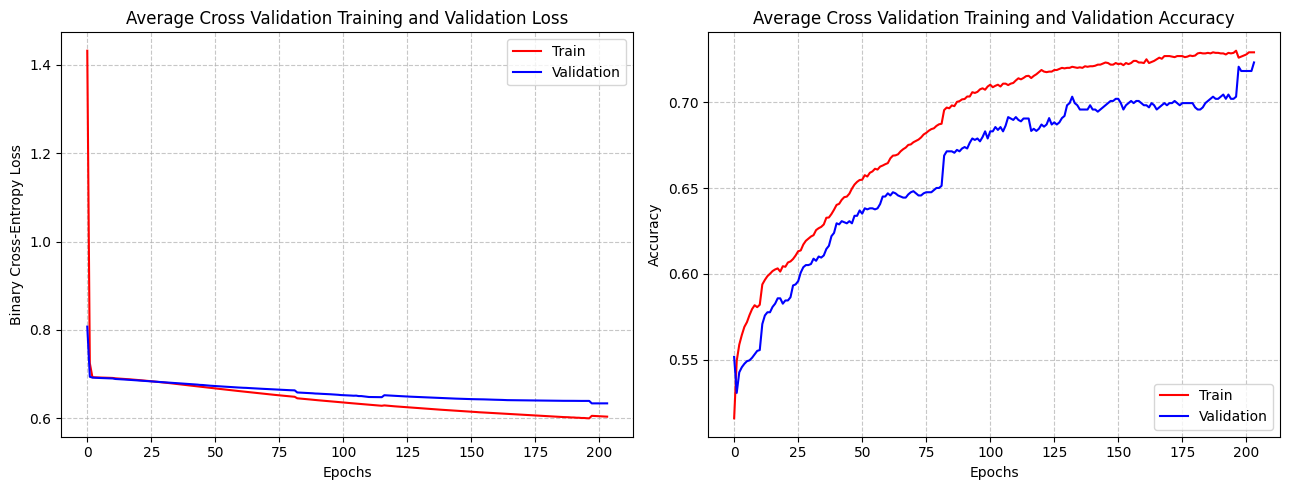

In [188]:
# Evaluating MLP 1
tf.keras.utils.set_random_seed(1)

# Perform cross-validation
mlp1base_cv_results = cross_validate_model_MLP1(
    data_train, 
    y_train,
    model_fn=MLP1ADAMHE,
    n_splits=5,
    epochs=500, 
    batch_size=32,
)

# Plot the cross-validation results showing the average training and validation metrics across all folds for each epoch
fig = plot_cross_validation_results_MLP1(mlp1base_cv_results)
plt.show()

# MLP Sequences

In [ ]:
#  All MLP 2 models
def MLP2BASE():
    model = Sequential()
    model.add(Embedding(num_words, 300, weights=[embedding_matrix], input_length=max_length, trainable=False))
    model.add(Flatten())
    model.add(Dense(5, activation='relu',))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', metrics=['acc'])
    return model

def MLP2EARLYSTOP():
    model = Sequential()
    model.add(Embedding(num_words, 300, weights=[embedding_matrix], input_length=max_length, trainable=False))
    model.add(Flatten())
    model.add(Dense(5, activation='relu',))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', metrics=['acc'])
    return model

def MLP2REG():
    model = Sequential()
    model.add(Embedding(num_words, 300, weights=[embedding_matrix], input_length=max_length, trainable=False))
    model.add(Flatten())
    model.add(Dense(5, activation='relu', kernel_regularizer=l2(0.06)))
    model.add(Dense(1, activation='sigmoid', kernel_regularizer=l2(0.06)))
    model.compile(loss='binary_crossentropy', metrics=['acc'])
    return model

def MLP2HEADAM():
    model = Sequential()
    model.add(Embedding(num_words, 300, weights=[embedding_matrix], input_length=max_length, trainable=False))
    model.add(Flatten())
    init_he_u = initializers.he_uniform(seed=None)
    model.add(Dense(16, activation='relu', kernel_regularizer=l2(0.07), kernel_initializer=init_he_u))
    model.add(Dense(1, activation='sigmoid', kernel_initializer=init_he_u))
    opt = optimizers.Adam(learning_rate=0.0007)
    model.compile(optimizer=opt,loss='binary_crossentropy', metrics=['accuracy'])
    return model

#  MLP 2 Optimised Model
# def MLP2():
#     model = Sequential()
#     model.add(Embedding(num_words, 300, weights=[embedding_matrix], input_length=max_length, trainable=True))
#     model.add(Flatten())
#     init_he_u = initializers.he_uniform(seed=None)
#     model.add(Dense(24, activation='relu', kernel_initializer=init_he_u, kernel_regularizer=l2(0.06)))
#     model.add(Dense(32, activation='relu', kernel_initializer=init_he_u, kernel_regularizer=l2(0.06)))
#     model.add(Dense(1, activation='sigmoid'))
#     opt = optimizers.Adam(learning_rate=0.0007)
#     model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['acc'])
#     return model

Epoch 1/100


/Users/matthew/Projects/DeeplearningA2/A2/lib/python3.12/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


51/51 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.6741 - loss: 1.4629 - val_accuracy: 0.7805 - val_loss: 0.5982
Epoch 2/100
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7933 - loss: 0.5842 - val_accuracy: 0.7805 - val_loss: 0.5836
Epoch 3/100
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8045 - loss: 0.5653 - val_accuracy: 0.7805 - val_loss: 0.5761
Epoch 4/100
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8126 - loss: 0.5549 - val_accuracy: 0.7830 - val_loss: 0.5699
Epoch 5/100
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8185 - loss: 0.5456 - val_accuracy: 0.7781 - val_loss: 0.5638
Epoch 6/100
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8209 - loss: 0.5369 - val_accuracy: 0.7805 - val_loss: 0.5583
Epoch 7/100
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8251 - loss: 0.5290 - val_accuracy: 0.7830 - val_loss: 0.5528
Epoch 8/100
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.8299 - loss: 0.5214 - val_accuracy: 0.7855 - val_loss: 0.5

/Users/matthew/Projects/DeeplearningA2/A2/lib/python3.12/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


51/51 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.7037 - loss: 1.4557 - val_accuracy: 0.8055 - val_loss: 0.5476
Epoch 2/100
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8043 - loss: 0.5406 - val_accuracy: 0.8055 - val_loss: 0.5360
Epoch 3/100
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8128 - loss: 0.5266 - val_accuracy: 0.8055 - val_loss: 0.5334
Epoch 4/100
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8171 - loss: 0.5198 - val_accuracy: 0.8005 - val_loss: 0.5307
Epoch 5/100
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8197 - loss: 0.5129 - val_accuracy: 0.8005 - val_loss: 0.5279
Epoch 6/100
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8261 - loss: 0.5071 - val_accuracy: 0.8055 - val_loss: 0.5254
Epoch 7/100
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8323 - loss: 0.5007 - val_accuracy: 0.8030 - val_loss: 0.5231
Epoch 8/100
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8364 - loss: 0.4959 - val_accuracy: 0.8055 - val_loss: 0.5

/Users/matthew/Projects/DeeplearningA2/A2/lib/python3.12/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


51/51 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.7226 - loss: 1.4523 - val_accuracy: 0.7332 - val_loss: 0.5974
Epoch 2/100
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8150 - loss: 0.5314 - val_accuracy: 0.7481 - val_loss: 0.5796
Epoch 3/100
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8352 - loss: 0.5126 - val_accuracy: 0.7531 - val_loss: 0.5762
Epoch 4/100
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8368 - loss: 0.5066 - val_accuracy: 0.7531 - val_loss: 0.5737
Epoch 5/100
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8448 - loss: 0.4998 - val_accuracy: 0.7556 - val_loss: 0.5707
Epoch 6/100
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8456 - loss: 0.4944 - val_accuracy: 0.7581 - val_loss: 0.5685
Epoch 7/100
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8507 - loss: 0.4891 - val_accuracy: 0.7681 - val_loss: 0.5654
Epoch 8/100
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8558 - loss: 0.4838 - val_accuracy: 0.7731 - val_loss: 0.5

/Users/matthew/Projects/DeeplearningA2/A2/lib/python3.12/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


51/51 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.7307 - loss: 1.4394 - val_accuracy: 0.7825 - val_loss: 0.5743
Epoch 2/100
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8047 - loss: 0.5533 - val_accuracy: 0.7800 - val_loss: 0.5615
Epoch 3/100
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8127 - loss: 0.5380 - val_accuracy: 0.7825 - val_loss: 0.5573
Epoch 4/100
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8179 - loss: 0.5301 - val_accuracy: 0.7925 - val_loss: 0.5523
Epoch 5/100
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8289 - loss: 0.5221 - val_accuracy: 0.7950 - val_loss: 0.5492
Epoch 6/100
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.8303 - loss: 0.5160 - val_accuracy: 0.7925 - val_loss: 0.5440
Epoch 7/100
51/51 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.8365 - loss: 0.5088 - val_accuracy: 0.8000 - val_loss: 0.5408
Epoch 8/100
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.8384 - loss: 0.5029 - val_accuracy: 0.8025 - val_loss: 0.

/Users/matthew/Projects/DeeplearningA2/A2/lib/python3.12/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


51/51 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.7187 - loss: 1.4438 - val_accuracy: 0.7900 - val_loss: 0.5586
Epoch 2/100
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8335 - loss: 0.5209 - val_accuracy: 0.7950 - val_loss: 0.5410
Epoch 3/100
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8423 - loss: 0.5044 - val_accuracy: 0.8025 - val_loss: 0.5363
Epoch 4/100
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8490 - loss: 0.4970 - val_accuracy: 0.8100 - val_loss: 0.5314
Epoch 5/100
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8511 - loss: 0.4902 - val_accuracy: 0.8075 - val_loss: 0.5276
Epoch 6/100
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8545 - loss: 0.4846 - val_accuracy: 0.8125 - val_loss: 0.5237
Epoch 7/100
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8608 - loss: 0.4785 - val_accuracy: 0.8175 - val_loss: 0.5204
Epoch 8/100
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8627 - loss: 0.4730 - val_accuracy: 0.8100 - val_loss: 0.5

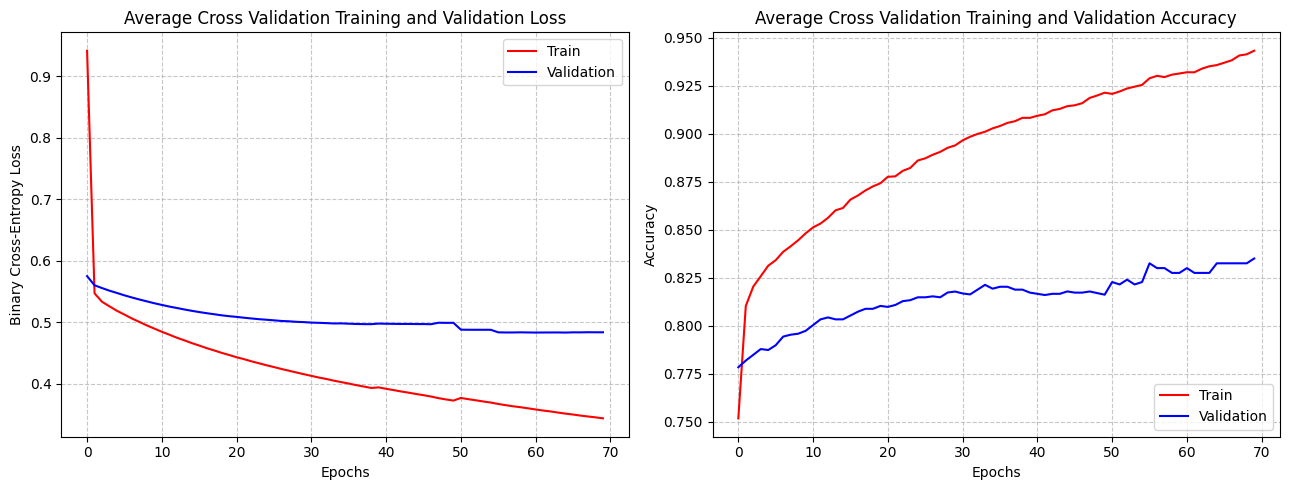

In [230]:
# Evaluating MLP 2
tf.keras.utils.set_random_seed(1)

# Perform cross-validation
mlp1base_cv_results = cross_validate_model_MLP1(
    x_train_seq, 
    y_train,
    model_fn=MLP2HEADAM,
    n_splits=5,
    epochs=100, 
    batch_size=32,
)

# Plot the cross-validation results showing the average training and validation metrics across all folds for each epoch
fig = plot_cross_validation_results_MLP1(mlp1base_cv_results)
plt.show()

# CNN Model

In [53]:
#  All CNN Models
def CNNBASE():
    model = Sequential()
    model.add(Embedding(num_words, 300, weights=[embedding_matrix], input_length=max_length, trainable=True))
    model.add(Conv1D(128, 5, activation='relu'))
    model.add(GlobalMaxPooling1D())
    model.add(Dense(10, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', metrics=['acc'])
    return model

def CNNREG():
    model = Sequential()
    model.add(Embedding(num_words, 300, weights=[embedding_matrix], input_length=max_length, trainable=True))
    model.add(Conv1D(128, 5, activation='relu', kernel_regularizer=l2(0.01)))
    model.add(Dropout(0.4))
    model.add(GlobalMaxPooling1D())
    model.add(Dense(10, activation='relu', kernel_regularizer=l2(0.01)))
    model.add(Dense(1, activation='sigmoid', kernel_regularizer=l2(0.01)))
    model.compile(loss='binary_crossentropy', metrics=['acc'])
    return model

#  CNN Optimised Model
def CNNFINAL():
    model = Sequential()
    model.add(Embedding(num_words, 300, weights=[embedding_matrix], input_length=max_length, trainable=True))
    init_he_u = initializers.he_uniform(seed=None)
    model.add(Conv1D(64, 5, activation='relu', kernel_initializer=init_he_u, kernel_regularizer=l2(0.01)))
    model.add(Dropout(0.4))
    model.add(Conv1D(64, 5, activation='relu', kernel_initializer=init_he_u, kernel_regularizer=l2(0.01)))
    model.add(GlobalMaxPooling1D())
    model.add(Dense(16, activation='relu', kernel_initializer=init_he_u, kernel_regularizer=l2(0.01)))
    model.add(Dense(1, activation='sigmoid', kernel_initializer=init_he_u, kernel_regularizer=l2(0.01)))
    opt = optimizers.Adam(learning_rate=0.001)
    model.compile(loss='binary_crossentropy', optimizer=opt , metrics=['acc'])
    return model

Epoch 1/100


/Users/matthew/Projects/DeeplearningA2/A2/lib/python3.12/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


26/26 ━━━━━━━━━━━━━━━━━━━━ 2s 38ms/step - acc: 0.5956 - loss: 0.6647 - val_acc: 0.5810 - val_loss: 0.6601
Epoch 2/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - acc: 0.7879 - loss: 0.5029 - val_acc: 0.7382 - val_loss: 0.5119
Epoch 3/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - acc: 0.8994 - loss: 0.3414 - val_acc: 0.7955 - val_loss: 0.4259
Epoch 4/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - acc: 0.9432 - loss: 0.2195 - val_acc: 0.7980 - val_loss: 0.4039
Epoch 5/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - acc: 0.9717 - loss: 0.1327 - val_acc: 0.8105 - val_loss: 0.4091
Epoch 6/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - acc: 0.9887 - loss: 0.0767 - val_acc: 0.7980 - val_loss: 0.5120
Epoch 7/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - acc: 0.9950 - loss: 0.0498 - val_acc: 0.8105 - val_loss: 0.4544
Epoch 8/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - acc: 0.9983 - loss: 0.0260 - val_acc: 0.8204 - val_loss: 0.4711
Epoch 9/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - acc: 0.9983 - 

/Users/matthew/Projects/DeeplearningA2/A2/lib/python3.12/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


26/26 ━━━━━━━━━━━━━━━━━━━━ 2s 41ms/step - acc: 0.6080 - loss: 0.6501 - val_acc: 0.7431 - val_loss: 0.5613
Epoch 2/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - acc: 0.8249 - loss: 0.4723 - val_acc: 0.7681 - val_loss: 0.4960
Epoch 3/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - acc: 0.9113 - loss: 0.3320 - val_acc: 0.8080 - val_loss: 0.4197
Epoch 4/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - acc: 0.9481 - loss: 0.2131 - val_acc: 0.8105 - val_loss: 0.4131
Epoch 5/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - acc: 0.9700 - loss: 0.1395 - val_acc: 0.8379 - val_loss: 0.3825
Epoch 6/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - acc: 0.9846 - loss: 0.0840 - val_acc: 0.8379 - val_loss: 0.4039
Epoch 7/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - acc: 0.9907 - loss: 0.0533 - val_acc: 0.8504 - val_loss: 0.4184
Epoch 8/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - acc: 0.9947 - loss: 0.0350 - val_acc: 0.8479 - val_loss: 0.4227
Epoch 9/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - acc: 0.9963 - 

/Users/matthew/Projects/DeeplearningA2/A2/lib/python3.12/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


26/26 ━━━━━━━━━━━━━━━━━━━━ 2s 40ms/step - acc: 0.5992 - loss: 0.6667 - val_acc: 0.5935 - val_loss: 0.6521
Epoch 2/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - acc: 0.7923 - loss: 0.5287 - val_acc: 0.7107 - val_loss: 0.5500
Epoch 3/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - acc: 0.8849 - loss: 0.3870 - val_acc: 0.7406 - val_loss: 0.4909
Epoch 4/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - acc: 0.9314 - loss: 0.2636 - val_acc: 0.7581 - val_loss: 0.4698
Epoch 5/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - acc: 0.9686 - loss: 0.1607 - val_acc: 0.7581 - val_loss: 0.4700
Epoch 6/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - acc: 0.9866 - loss: 0.0873 - val_acc: 0.7681 - val_loss: 0.4863
Epoch 7/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - acc: 0.9979 - loss: 0.0455 - val_acc: 0.7756 - val_loss: 0.5103
Epoch 8/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - acc: 1.0000 - loss: 0.0217 - val_acc: 0.7681 - val_loss: 0.5476
Epoch 9/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - acc: 1.0000 - 

/Users/matthew/Projects/DeeplearningA2/A2/lib/python3.12/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


26/26 ━━━━━━━━━━━━━━━━━━━━ 2s 40ms/step - acc: 0.6081 - loss: 0.6565 - val_acc: 0.7000 - val_loss: 0.5385
Epoch 2/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - acc: 0.8555 - loss: 0.4234 - val_acc: 0.7925 - val_loss: 0.4520
Epoch 3/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - acc: 0.9208 - loss: 0.2833 - val_acc: 0.8050 - val_loss: 0.4236
Epoch 4/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - acc: 0.9595 - loss: 0.1787 - val_acc: 0.8075 - val_loss: 0.4002
Epoch 5/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step - acc: 0.9819 - loss: 0.1108 - val_acc: 0.8300 - val_loss: 0.3824
Epoch 6/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - acc: 0.9933 - loss: 0.0561 - val_acc: 0.8225 - val_loss: 0.4343
Epoch 7/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step - acc: 0.9988 - loss: 0.0341 - val_acc: 0.8275 - val_loss: 0.3994
Epoch 8/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - acc: 0.9997 - loss: 0.0150 - val_acc: 0.8400 - val_loss: 0.4132
Epoch 9/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - acc: 1.0000 - 

/Users/matthew/Projects/DeeplearningA2/A2/lib/python3.12/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


26/26 ━━━━━━━━━━━━━━━━━━━━ 2s 37ms/step - acc: 0.6138 - loss: 0.6407 - val_acc: 0.6125 - val_loss: 0.6226
Epoch 2/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - acc: 0.8432 - loss: 0.4032 - val_acc: 0.7825 - val_loss: 0.4636
Epoch 3/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - acc: 0.9206 - loss: 0.2674 - val_acc: 0.8000 - val_loss: 0.4372
Epoch 4/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - acc: 0.9658 - loss: 0.1645 - val_acc: 0.8000 - val_loss: 0.4320
Epoch 5/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - acc: 0.9818 - loss: 0.1002 - val_acc: 0.8075 - val_loss: 0.4270
Epoch 6/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - acc: 0.9855 - loss: 0.0617 - val_acc: 0.8225 - val_loss: 0.4271
Epoch 7/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - acc: 0.9938 - loss: 0.0326 - val_acc: 0.8050 - val_loss: 0.4698
Epoch 8/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - acc: 0.9986 - loss: 0.0186 - val_acc: 0.8325 - val_loss: 0.4661
Epoch 9/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step - acc: 0.9994 - 

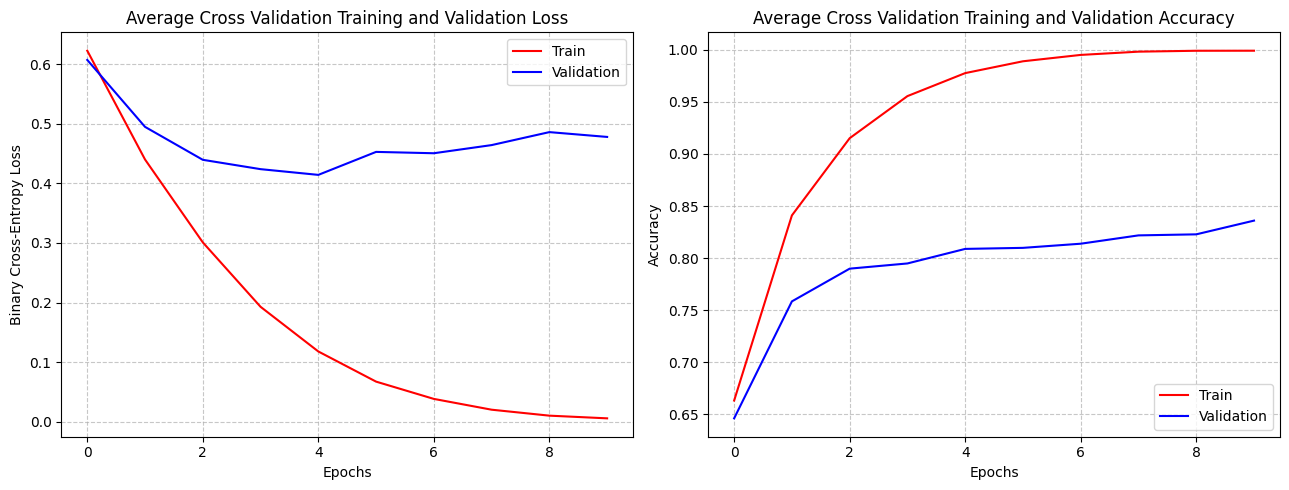

In [68]:
# Evaluating CNN
tf.keras.utils.set_random_seed(1)

# Perform cross-validation
CNN_cv_results = cross_validate_model_MLP1(
    x_train_seq, 
    y_train,
    model_fn=CNNBASE,
    n_splits=5,
    epochs=100, 
    batch_size=64,
)

# Plot the cross-validation results showing the average training and validation metrics across all folds for each epoch
fig = plot_cross_validation_results_MLP1(CNN_cv_results)
plt.show()

# RNN Model

In [92]:
# All RNN Models

def RNNBASE():
    model = Sequential()
    model.add(Embedding(num_words, output_dim=300, weights=[embedding_matrix], input_length=87, trainable=True, mask_zero = True))
    model.add(LSTM(64))
    model.add(Dense(265, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', metrics=['acc'])
    return model

def RNNREG():
    model = Sequential()
    model.add(Embedding(input_dim=vocab_size, output_dim=300, weights=[bert_embedding_matrix], input_length=87, trainable=True, mask_zero = True))
    init_he_u = initializers.he_uniform(seed=None)
    model.add(LSTM(64, dropout=0.1, recurrent_dropout=0.1, kernel_regularizer=l2(0.01)))
    model.add(Dense(256, activation='relu', kernel_regularizer=l2(0.01)))
    model.add(Dense(1, activation='sigmoid', kernel_regularizer=l2(0.01)))
    model.compile(loss='binary_crossentropy', metrics=['acc'])
    return model

def RNNOPT():
    model = Sequential()
    model.add(Embedding(num_words, output_dim=300, weights=[embedding_matrix], input_length=87, trainable=True, mask_zero = True))
    init_he_u = initializers.he_uniform(seed=None)
    model.add(LSTM(64, dropout=0.1, recurrent_dropout=0.1, kernel_initializer=init_he_u, kernel_regularizer=l2(0.01)))
    model.add(Dense(128, activation='relu', kernel_initializer=init_he_u, kernel_regularizer=l2(0.01)))
    model.add(Dense(1, activation='sigmoid', kernel_initializer=init_he_u, kernel_regularizer=l2(0.01)))
    opt = optimizers.Adam(learning_rate=0.001)
    model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['acc'])
    return model

def RNNBERT():
    model = Sequential()
    model.add(Embedding(input_dim=vocab_size, output_dim=768, weights=[bert_embedding_matrix], input_length=87, trainable=True, mask_zero = True))
    init_he_u = initializers.he_uniform(seed=None)
    model.add(LSTM(64, dropout=0.1, recurrent_dropout=0.1, kernel_regularizer=l2(0.01)))
    model.add(Dense(256, activation='relu', kernel_initializer=init_he_u, kernel_regularizer=l2(0.01)))
    model.add(Dense(1, activation='sigmoid', kernel_initializer=init_he_u, kernel_regularizer=l2(0.01)))
    opt = optimizers.Adam(learning_rate=0.001)
    model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['acc'])
    return model


Epoch 1/100


/Users/matthew/Projects/DeeplearningA2/A2/lib/python3.12/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


26/26 ━━━━━━━━━━━━━━━━━━━━ 5s 129ms/step - acc: 0.5580 - loss: 7.7145 - val_acc: 0.7382 - val_loss: 5.5930
Epoch 2/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 3s 124ms/step - acc: 0.7979 - loss: 5.0432 - val_acc: 0.7930 - val_loss: 3.7258
Epoch 3/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 3s 116ms/step - acc: 0.8481 - loss: 3.3522 - val_acc: 0.8055 - val_loss: 2.6072
Epoch 4/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 3s 120ms/step - acc: 0.9056 - loss: 2.2952 - val_acc: 0.8354 - val_loss: 1.9086
Epoch 5/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 3s 119ms/step - acc: 0.9449 - loss: 1.6203 - val_acc: 0.8429 - val_loss: 1.4735
Epoch 6/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 3s 120ms/step - acc: 0.9607 - loss: 1.1714 - val_acc: 0.8404 - val_loss: 1.2206
Epoch 7/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 3s 118ms/step - acc: 0.9538 - loss: 0.9055 - val_acc: 0.8279 - val_loss: 1.0573
Epoch 8/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 3s 117ms/step - acc: 0.9575 - loss: 0.7184 - val_acc: 0.8304 - val_loss: 0.9931
Epoch 9/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 3s 118ms/step - acc: 

/Users/matthew/Projects/DeeplearningA2/A2/lib/python3.12/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


26/26 ━━━━━━━━━━━━━━━━━━━━ 5s 127ms/step - acc: 0.5446 - loss: 7.6936 - val_acc: 0.7481 - val_loss: 5.5934
Epoch 2/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 3s 111ms/step - acc: 0.7882 - loss: 5.0717 - val_acc: 0.8180 - val_loss: 3.7018
Epoch 3/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 3s 112ms/step - acc: 0.8509 - loss: 3.3603 - val_acc: 0.8354 - val_loss: 2.5616
Epoch 4/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 3s 118ms/step - acc: 0.9049 - loss: 2.2975 - val_acc: 0.8529 - val_loss: 1.8473
Epoch 5/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 3s 116ms/step - acc: 0.9359 - loss: 1.6122 - val_acc: 0.8579 - val_loss: 1.4124
Epoch 6/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 3s 118ms/step - acc: 0.9653 - loss: 1.1688 - val_acc: 0.8130 - val_loss: 1.2670
Epoch 7/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 3s 114ms/step - acc: 0.9544 - loss: 0.9127 - val_acc: 0.8778 - val_loss: 0.9562
Epoch 8/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 3s 116ms/step - acc: 0.9663 - loss: 0.7154 - val_acc: 0.8229 - val_loss: 0.9358
Epoch 9/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 3s 121ms/step - acc: 

/Users/matthew/Projects/DeeplearningA2/A2/lib/python3.12/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


26/26 ━━━━━━━━━━━━━━━━━━━━ 5s 126ms/step - acc: 0.5571 - loss: 7.6293 - val_acc: 0.7382 - val_loss: 5.5547
Epoch 2/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 3s 115ms/step - acc: 0.7776 - loss: 4.9974 - val_acc: 0.7706 - val_loss: 3.6907
Epoch 3/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 3s 111ms/step - acc: 0.8702 - loss: 3.2619 - val_acc: 0.7980 - val_loss: 2.5822
Epoch 4/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 3s 114ms/step - acc: 0.9102 - loss: 2.2230 - val_acc: 0.7830 - val_loss: 1.9614
Epoch 5/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 3s 118ms/step - acc: 0.9329 - loss: 1.5847 - val_acc: 0.7980 - val_loss: 1.5274
Epoch 6/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 3s 122ms/step - acc: 0.9453 - loss: 1.1758 - val_acc: 0.7307 - val_loss: 1.4810
Epoch 7/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 3s 118ms/step - acc: 0.9264 - loss: 0.9490 - val_acc: 0.8429 - val_loss: 1.0126
Epoch 8/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 3s 118ms/step - acc: 0.9662 - loss: 0.7208 - val_acc: 0.8304 - val_loss: 0.9200
Epoch 9/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 3s 115ms/step - acc: 

/Users/matthew/Projects/DeeplearningA2/A2/lib/python3.12/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


26/26 ━━━━━━━━━━━━━━━━━━━━ 5s 121ms/step - acc: 0.5521 - loss: 7.6527 - val_acc: 0.7800 - val_loss: 5.5671
Epoch 2/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 3s 121ms/step - acc: 0.7855 - loss: 5.0068 - val_acc: 0.8075 - val_loss: 3.6475
Epoch 3/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 3s 115ms/step - acc: 0.8456 - loss: 3.2931 - val_acc: 0.8275 - val_loss: 2.5556
Epoch 4/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 3s 115ms/step - acc: 0.8832 - loss: 2.2604 - val_acc: 0.8150 - val_loss: 1.9529
Epoch 5/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 3s 121ms/step - acc: 0.9234 - loss: 1.6047 - val_acc: 0.8125 - val_loss: 1.5847
Epoch 6/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 3s 122ms/step - acc: 0.9208 - loss: 1.2198 - val_acc: 0.8400 - val_loss: 1.1752
Epoch 7/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 3s 117ms/step - acc: 0.9457 - loss: 0.9220 - val_acc: 0.8575 - val_loss: 0.9757
Epoch 8/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 3s 125ms/step - acc: 0.9749 - loss: 0.6955 - val_acc: 0.8550 - val_loss: 0.8983
Epoch 9/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 3s 127ms/step - acc: 

/Users/matthew/Projects/DeeplearningA2/A2/lib/python3.12/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


26/26 ━━━━━━━━━━━━━━━━━━━━ 5s 125ms/step - acc: 0.6120 - loss: 7.5843 - val_acc: 0.7400 - val_loss: 5.5222
Epoch 2/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 3s 115ms/step - acc: 0.8057 - loss: 4.9513 - val_acc: 0.7900 - val_loss: 3.6823
Epoch 3/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 3s 116ms/step - acc: 0.8770 - loss: 3.2812 - val_acc: 0.8225 - val_loss: 2.5773
Epoch 4/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 3s 117ms/step - acc: 0.9031 - loss: 2.2534 - val_acc: 0.8200 - val_loss: 1.9017
Epoch 5/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 3s 115ms/step - acc: 0.9419 - loss: 1.5988 - val_acc: 0.7825 - val_loss: 1.5648
Epoch 6/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 3s 132ms/step - acc: 0.9508 - loss: 1.1871 - val_acc: 0.7900 - val_loss: 1.3001
Epoch 7/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 3s 126ms/step - acc: 0.9433 - loss: 0.9310 - val_acc: 0.8475 - val_loss: 0.9949
Epoch 8/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 3s 120ms/step - acc: 0.9726 - loss: 0.7043 - val_acc: 0.8450 - val_loss: 0.8454
Epoch 9/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 3s 116ms/step - acc: 

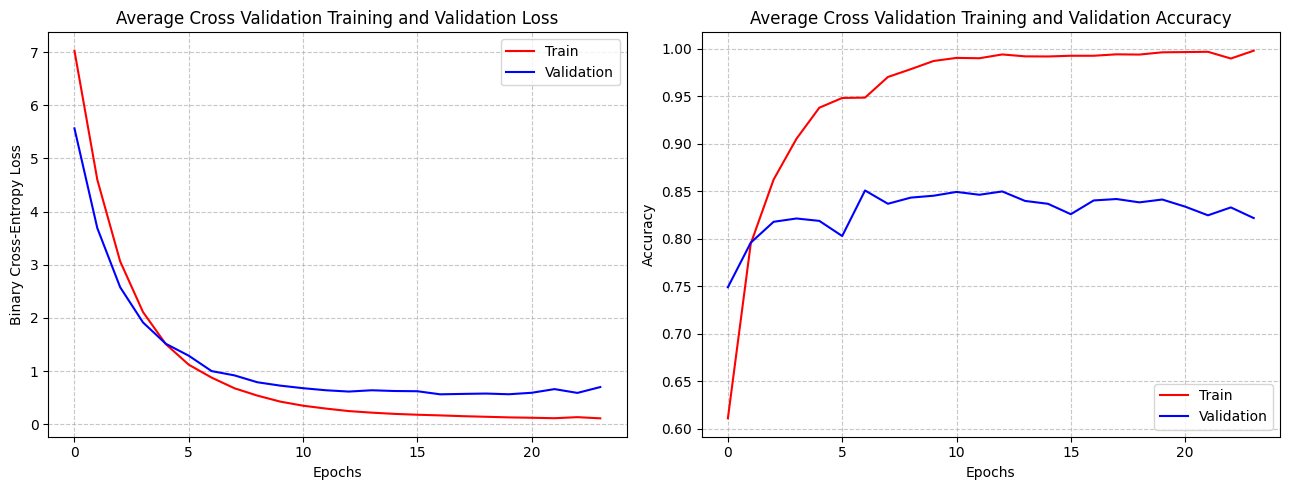

In [93]:
# Evaluating RNN
tf.keras.utils.set_random_seed(1)

# Perform cross-validation
RNN_cv_results = cross_validate_model_MLP1(
    x_train_seq, 
    y_train,
    model_fn=RNNOPT,
    n_splits=5,
    epochs=100, 
    batch_size=64,
)

# Plot the cross-validation results showing the average training and validation metrics across all folds for each epoch
fig = plot_cross_validation_results_MLP1(RNN_cv_results)
plt.show()